In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from circuits_ttt import *
plt.rcParams.update({'font.size': 14})
from textwrap import wrap
from matplotlib.gridspec import GridSpec

/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Loading games and labels
Data loading complete
Loading games and labels but excluding equivalent games under symmetry
Data loading complete


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def single_plots(base_path, start, n=20, save=False):
    for marker in range(start,start+n):
        filenames = next(os.walk(base_path+str(marker)), (None, None, []))[2]
        symmetric = [np.load(base_path + str(marker) + '/' + str(i), allow_pickle=True).item() for i in filenames if i != 'params.txt']
        
        with open(base_path+str(marker)+'/params.txt') as f:
            params = f.readlines()[0]
        
        args = params.split(" ")
        layout = args[args.index('-l')+1]
    
        #plt.figure(figsize=(16, 8))
        fig = plt.figure(figsize=(20, 10))
        gs = GridSpec(nrows=2, ncols=3, width_ratios=[3, 1, 0.08])

        epoch_acc = np.array([i['total accuracy'] for i in symmetric])
        epoch_train_acc = np.array([i['training accuracy'] for i in symmetric])
        epoch_cost = (torch.tensor([i['cost function'] for i in symmetric])).detach().numpy()
        avg_epoch_acc = np.average(epoch_acc, axis=0)
        avg_epoch_train_acc = np.average(epoch_train_acc, axis=0)
        avg_epoch_cost = np.average(epoch_cost, axis=0)
        #plt.ylabel('accuracy')

        ax0 = fig.add_subplot(gs[:, 0])
        ax0.set_xlabel('step')
        
        ax0.plot([i.trace()/6 for i in avg_epoch_acc], label='Total accuracy',color='blue')
        for j in epoch_acc:
            ax0.plot([i.trace()/6 for i in j], color='blue',alpha=0.1)
        
        ax0.plot([i.trace()/6 for i in avg_epoch_train_acc], label='Training data accuracy',color='red')
        for j in epoch_train_acc:
            ax0.plot([i.trace()/6 for i in j], color='red',alpha=0.1)
            
        ax0.plot(avg_epoch_cost, label='cost function',color='green')
        for i in symmetric:
            ax0.plot((torch.tensor(i['cost function'])).detach().numpy(), color='green',alpha=0.1)
        
        #ax = plt.gca()
        #ax0.set_ylim([-0.05, 1])
        plt.legend()
        plt.grid()
        
        # plot confusion matrices
        ax2 = fig.add_subplot(gs[0, 1])
        pos = ax2.imshow(np.average(epoch_acc[:][-1], axis=0), cmap='plasma')
        ax2.set_xticks(list(range(6)))
        #ax0.set_xticklabels(list(np.round(np.linspace(0,  1, 6), 2)))
        ax2.set_xticklabels('')
        ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
        ax2.set_ylabel('difficulty')

        ax1 = fig.add_subplot(gs[1, 1])
        ax1.imshow(np.average(epoch_train_acc[:][-1], axis=0), cmap='plasma')
        ax1.set_xticks(list(range(6)))
        ax1.set_xticklabels(list(np.round(np.linspace(0, 1, 6), 2)))
        ax1.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
        ax1.set_xlabel('difficulty')
        ax1.set_ylabel('difficulty')

        cbarspec = gs[:, 2].subgridspec(3, 1, height_ratios=[0.2, 1, 0.2])
        colorbar = fig.add_subplot(cbarspec[1])

        ax0.set_ylim([-0.1, 1.1])
        ax2.set_title('total accuracy')
        ax1.set_title('training accuracy')

        fig.colorbar(pos, cax=colorbar, shrink=0.6)
        
        #plt.title('symm\n'+params)
        if symmetric[0]['symmetric']:
            symm = 'symm'
        else:
            symm = 'asymm'
        ax0.set_title(f'{symm}, layout: {args[7]}, repetitions {args[13]}')
        if save:
            plt.savefig(base_path+f'/figs/{symm}_'+str(marker))
        #plt.show()

In [4]:
def overview_plot(base_path, start, n=20, save=False):
    i = 0
    lp_list = []
    subplot_markers = {}
    for marker in range(start,start+n):
        with open(base_path+str(marker)+'/params.txt') as f:
            params = f.readlines()[0]
            #print(params)
            args = params.split(" ")
            ind = (int(args[args.index('-re')+1]) , int((len(args[args.index('-l')+1])-1)/6))
            lp_list.append(ind)
            #print(args[args.index('-re')]+' '+args[args.index('-re')+1]+' layout: '+args[args.index('-l')+1]+' '+str(ind))
            subplot_markers[marker] = ind
            i+=1

    columns = 5
    rows = 5
    fig, ax_array = plt.subplots(rows, columns,squeeze=True, sharex='all', sharey='all', figsize=(20,15))
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)

    fig.patch.set_facecolor('white')

    for marker in range(start,start+n):
        
        filenames = next(os.walk(base_path+str(marker)), (None, None, []))[2]
        symmetric = [np.load(base_path + str(marker) + '/' + str(i), allow_pickle=True).item() for i in filenames if i != 'params.txt']
        
        with open(base_path+str(marker)+'/params.txt') as f:
            params = f.readlines()[0]
        
        args = params.split(" ")


        #ind = (int(args[args.index('-re')+1]) , int((len(args[args.index('-l')+1])-1)/6))

        x,y = subplot_markers[marker]
        
        
        #print(x,' ',y,' ', 'marker = ',marker)
        
        
        a = ax_array[x-1,y-1]
        
        
        
        if len(filenames)>1:
            a.text(1, 0.9, f'l,p = {x}, {y}')
            
            epoch_acc = np.array([i['total accuracy'][:100]  for i in symmetric])
            epoch_train_acc = np.array([i['training accuracy'][:100]  for i in symmetric])
            epoch_cost = (torch.tensor([i['cost function'][:100] for i in symmetric])).detach().numpy()
            avg_epoch_acc = np.average(epoch_acc, axis=0)
            avg_epoch_train_acc = np.average(epoch_train_acc, axis=0)
            avg_epoch_cost = np.average(epoch_cost, axis=0)
            #plt.ylabel('accuracy')
        
        


            #a.xlabel('epoch')
            #print(len(filenames))
            a.plot([i.trace()/6 for i in avg_epoch_acc], label='Total accuracy',color='blue')
            for j in epoch_acc:
                a.plot([i.trace()/6 for i in j], color='blue',alpha=0.15)

            a.plot([i.trace()/6 for i in avg_epoch_train_acc], label='Training data accuracy',color='red')
            for j in epoch_train_acc:
                a.plot([i.trace()/6 for i in j], color='red',alpha=0.15)

            a.plot(avg_epoch_cost, label='cost function',color='green')
            for i in symmetric:
                a.plot((torch.tensor(i['cost function'])).detach().numpy(), color='green',alpha=0.15)

            #ax = plt.gca()
            a.set_ylim([-0.05, 1])
            a.grid()
            #print('=================== done ================')
        else:
            print(f'no data for l,p = {x},{y}')
    
    if symmetric[0]['symmetric']:
        symm = 'Symmetric'
        symm2 = 'symm'
    else:
        symm = 'Asymmetric'
        symm2 = 'asymm'

    fig.suptitle(f'{symm}; c-op: CRZ; 30 steps; l times data encoding followed each by p times cemoid')
    if save:
        plt.savefig(base_path+f'/figs/{symm2}_overview')

    #plt.show()

# l-p sweep

In [5]:
base_path = os.getcwd() + '/cluster_pdg/pdg_lp_sweep_1/'

## Symmetric case

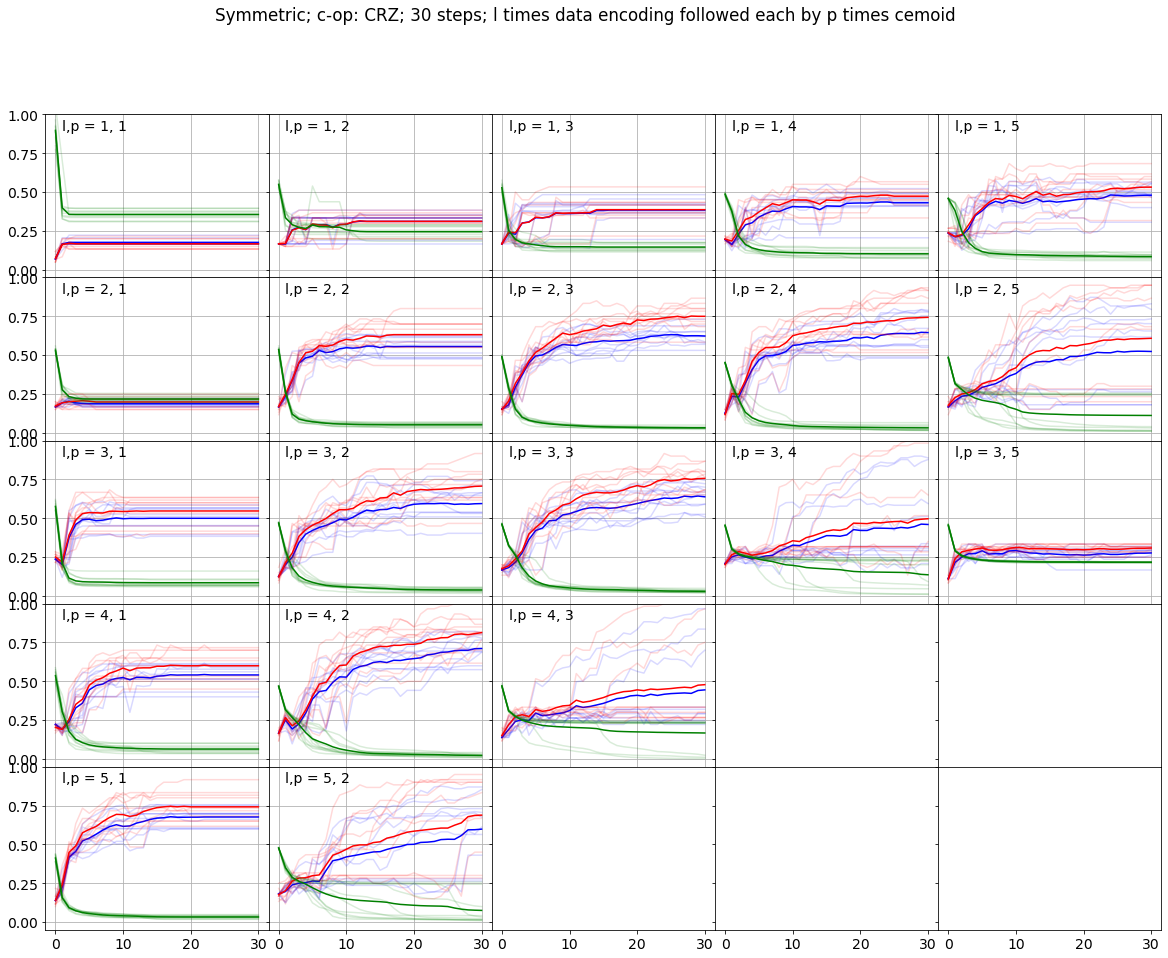

In [6]:
overview_plot(base_path, 8000, save=True)

<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator


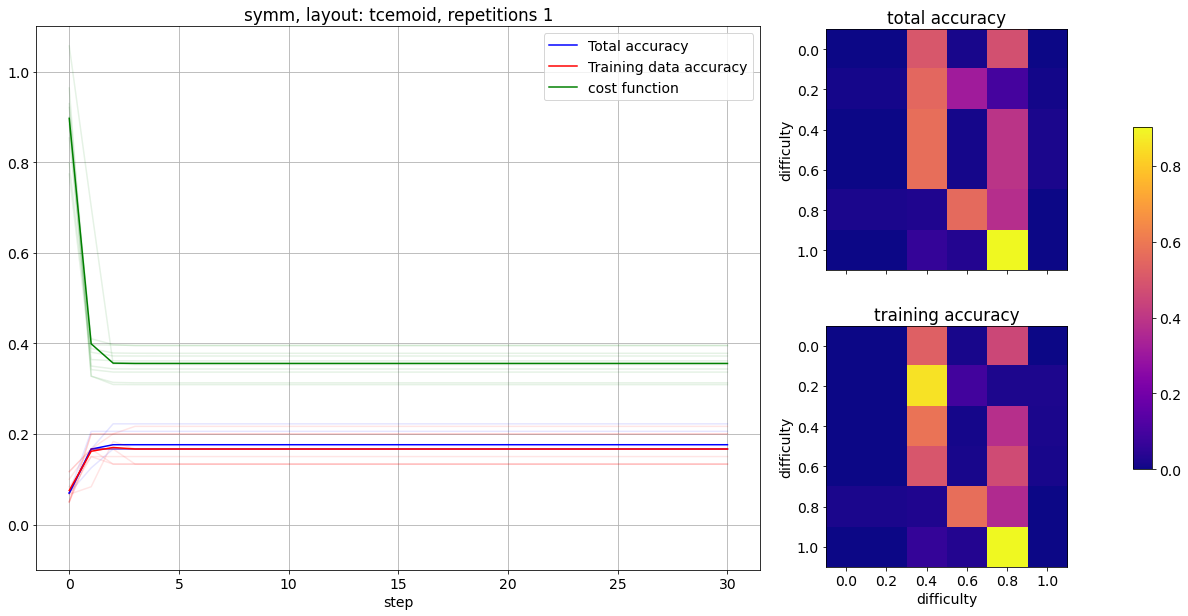

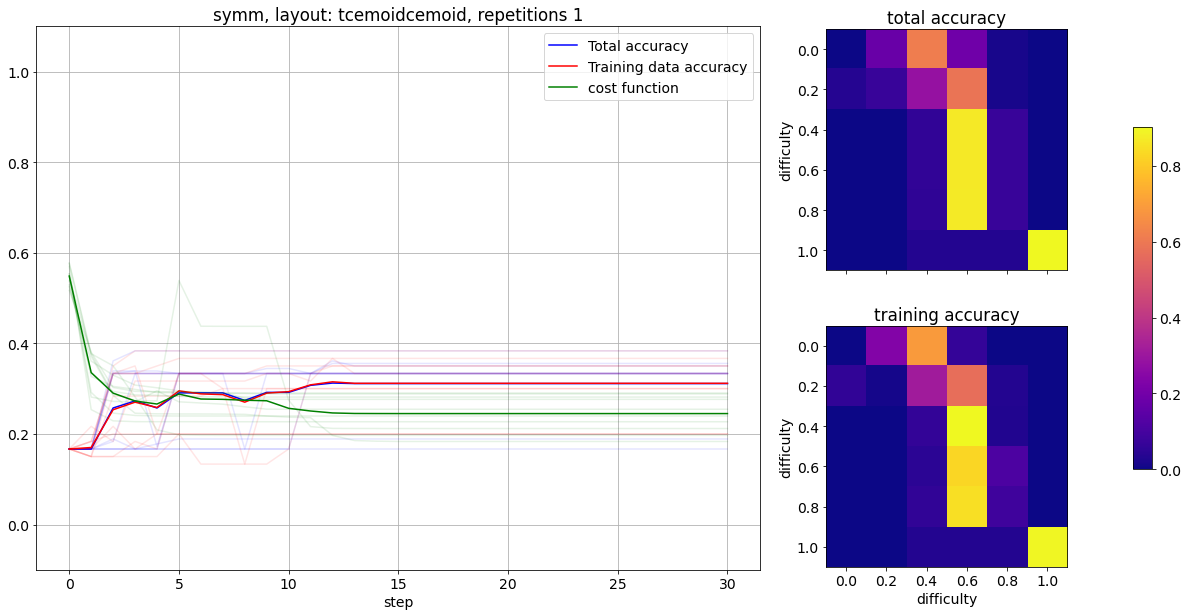

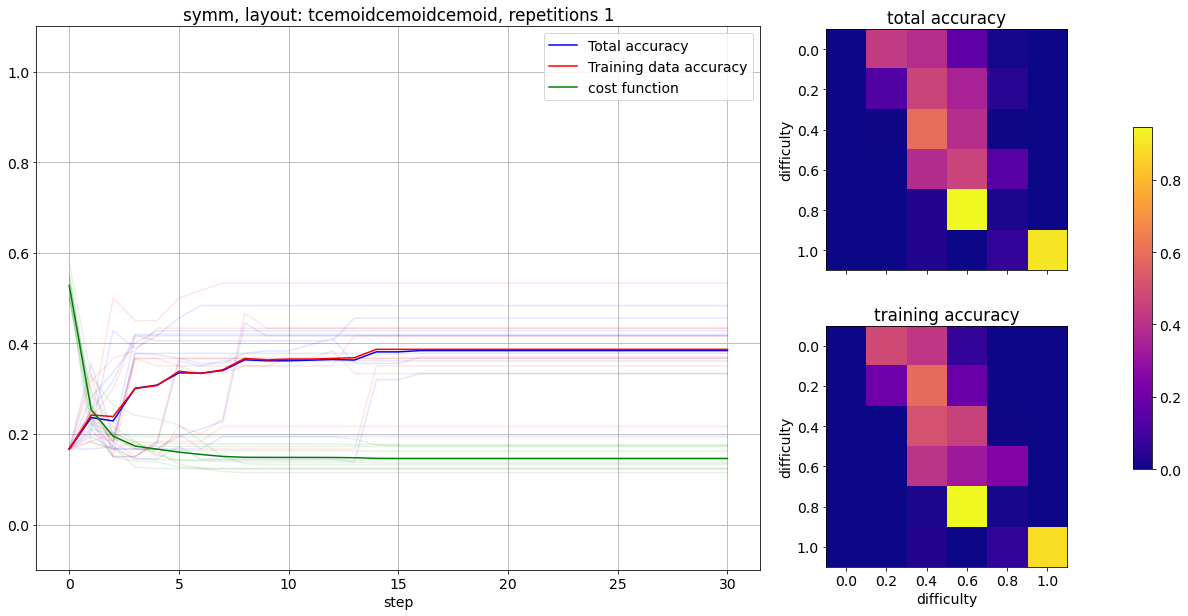

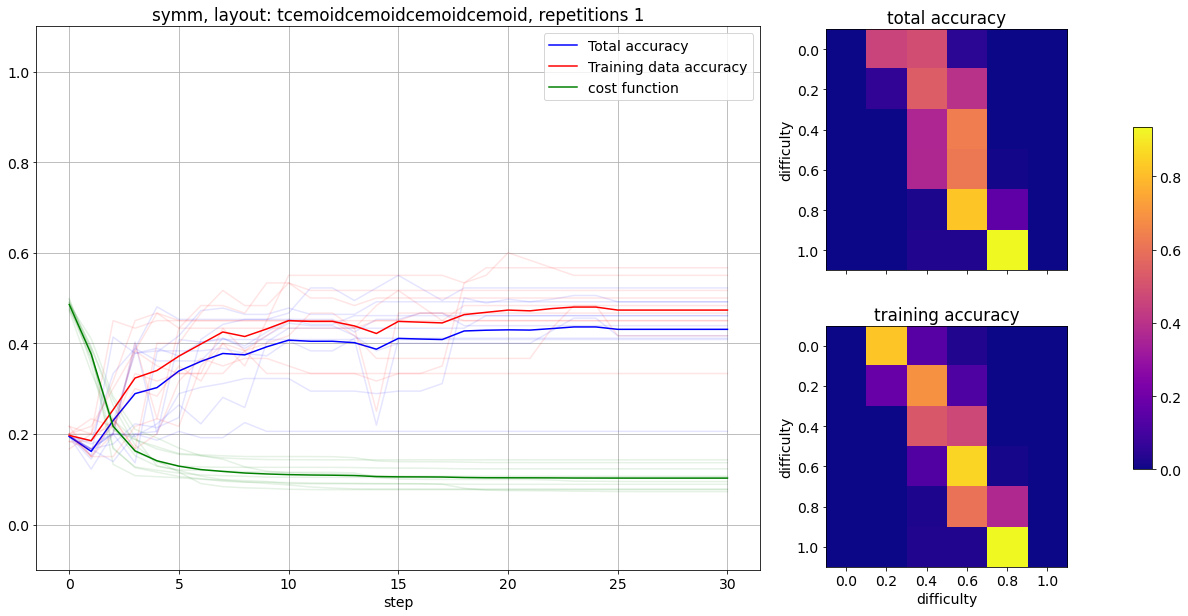

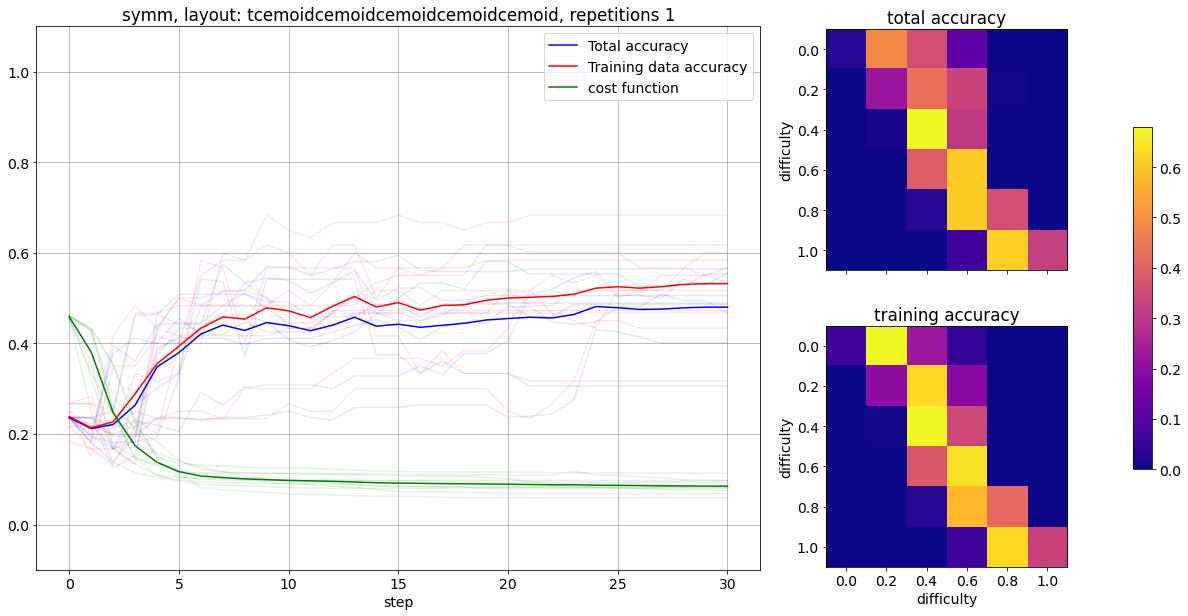

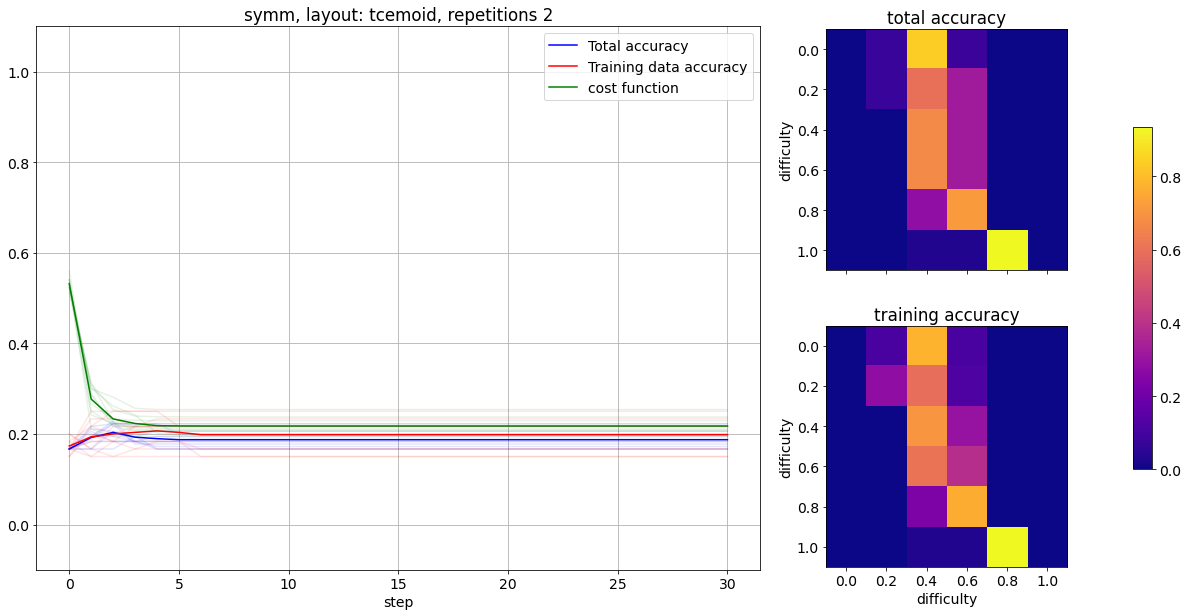

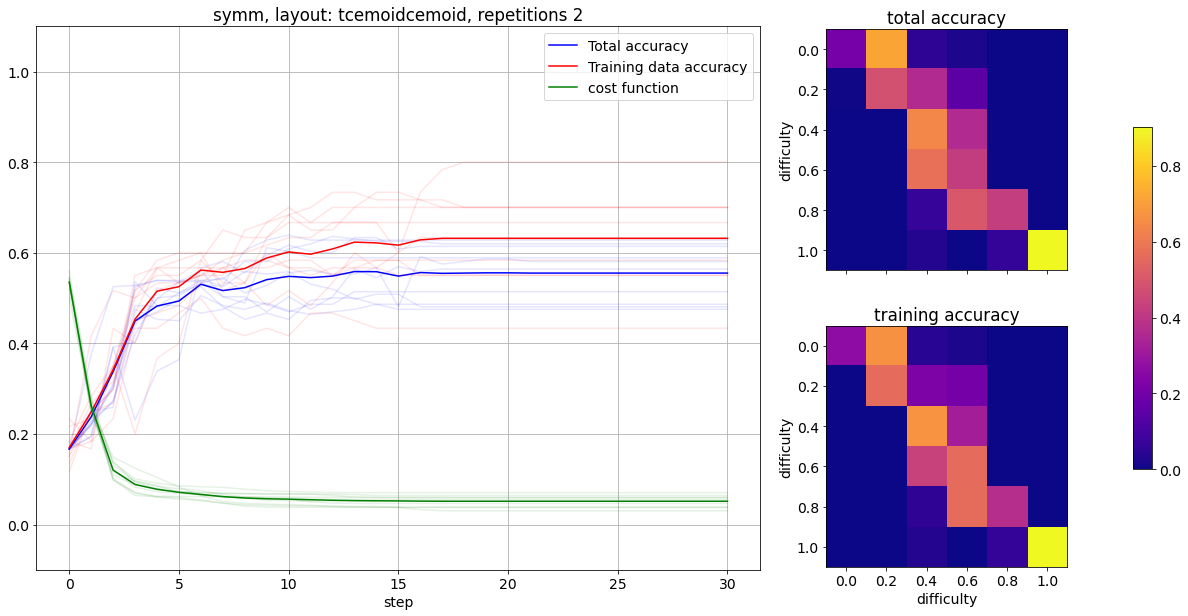

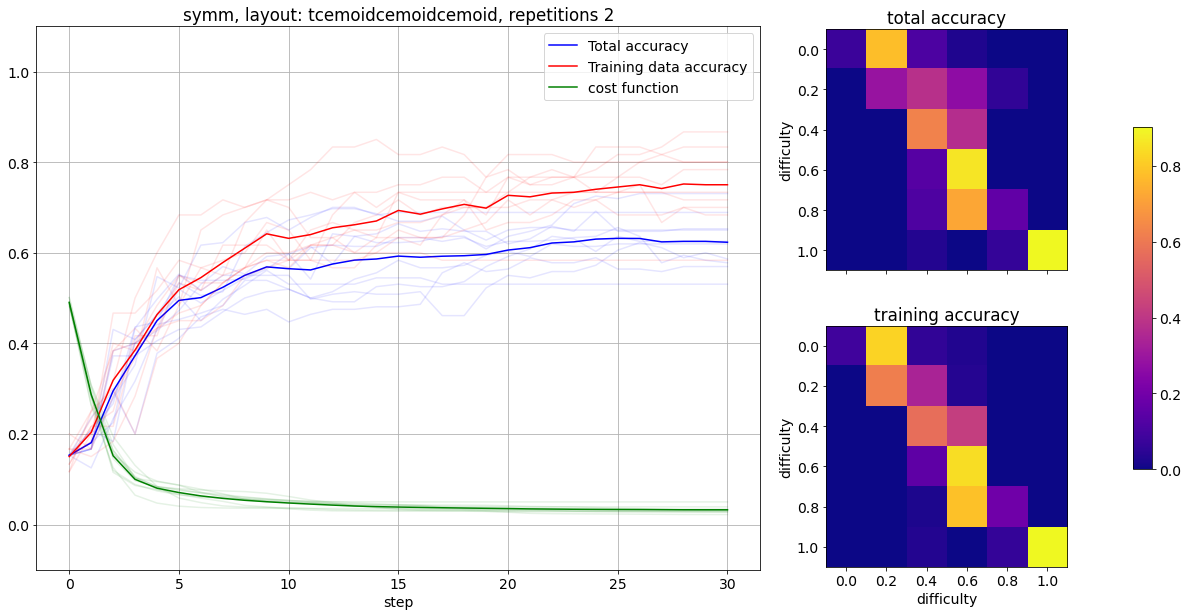

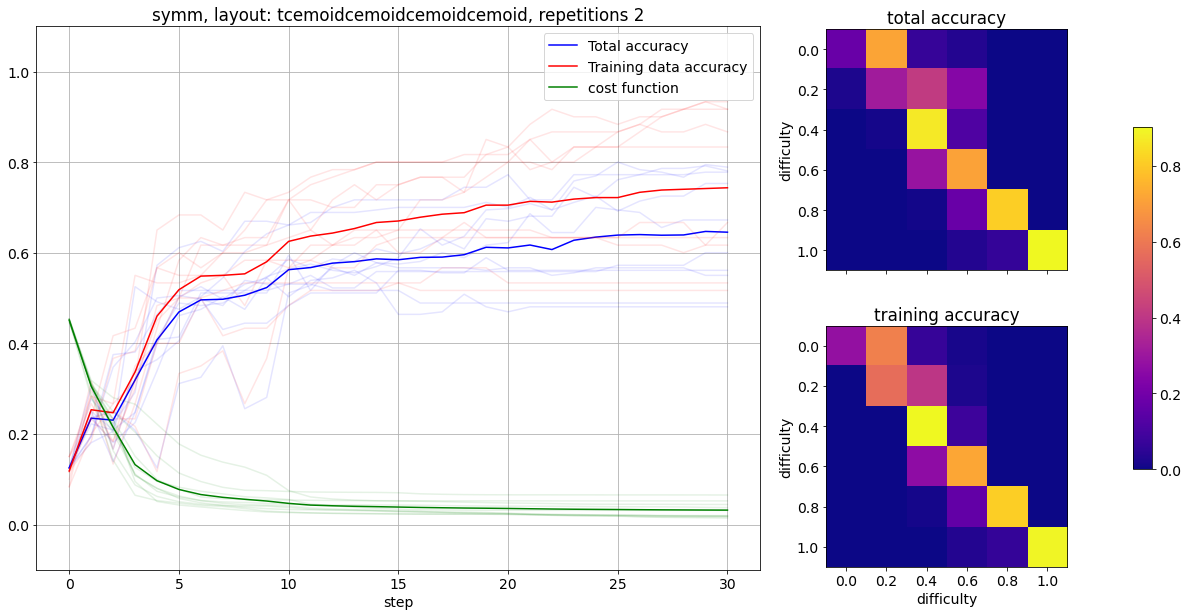

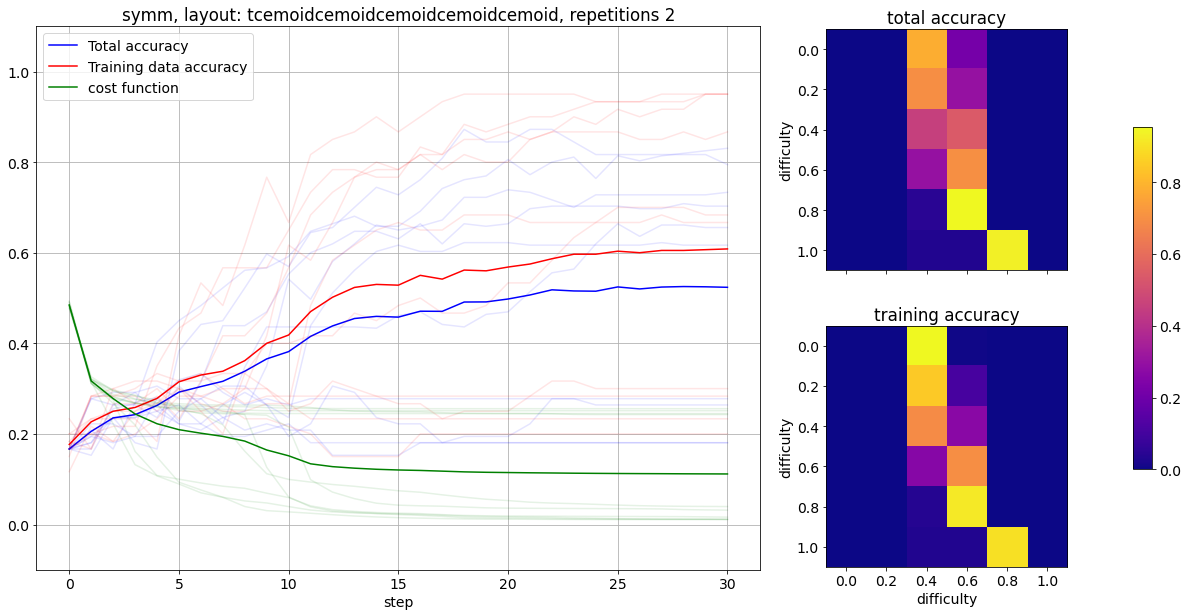

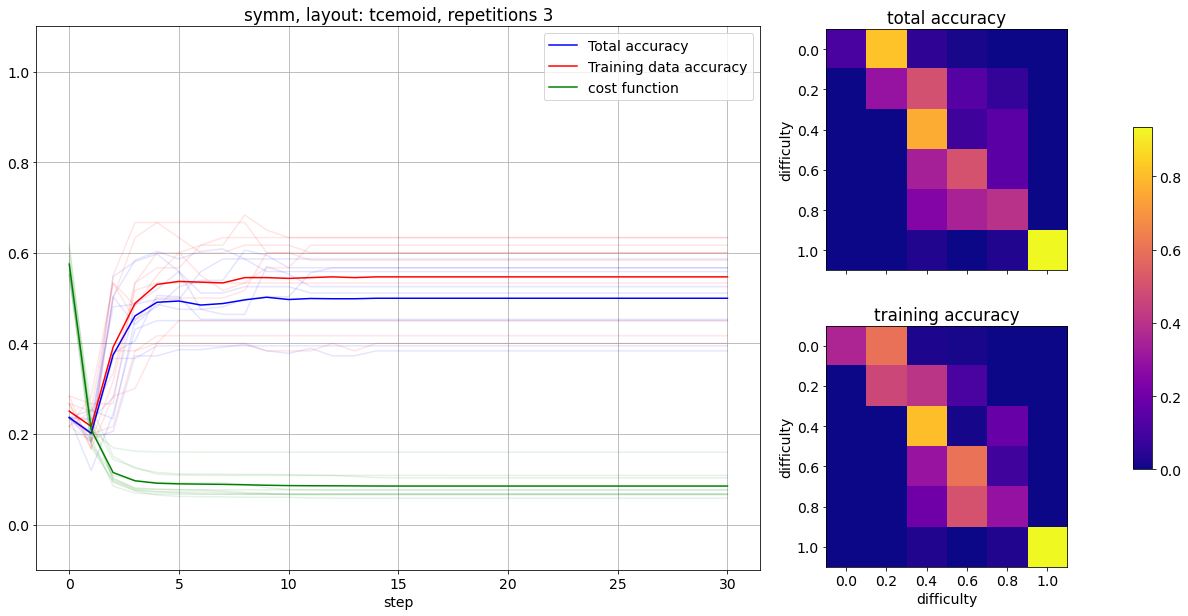

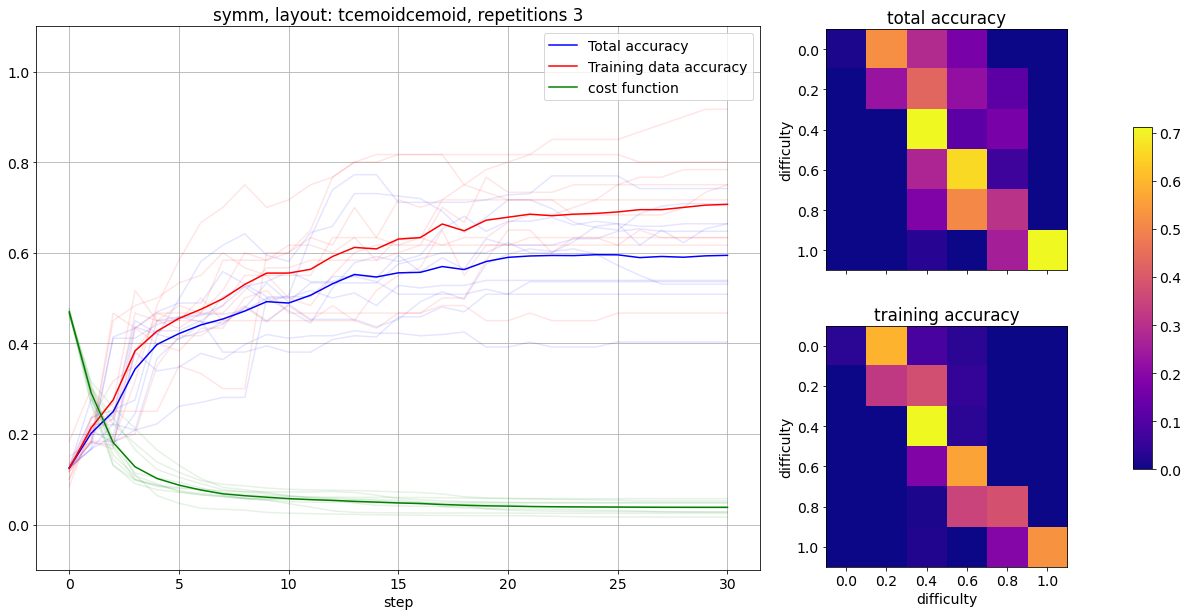

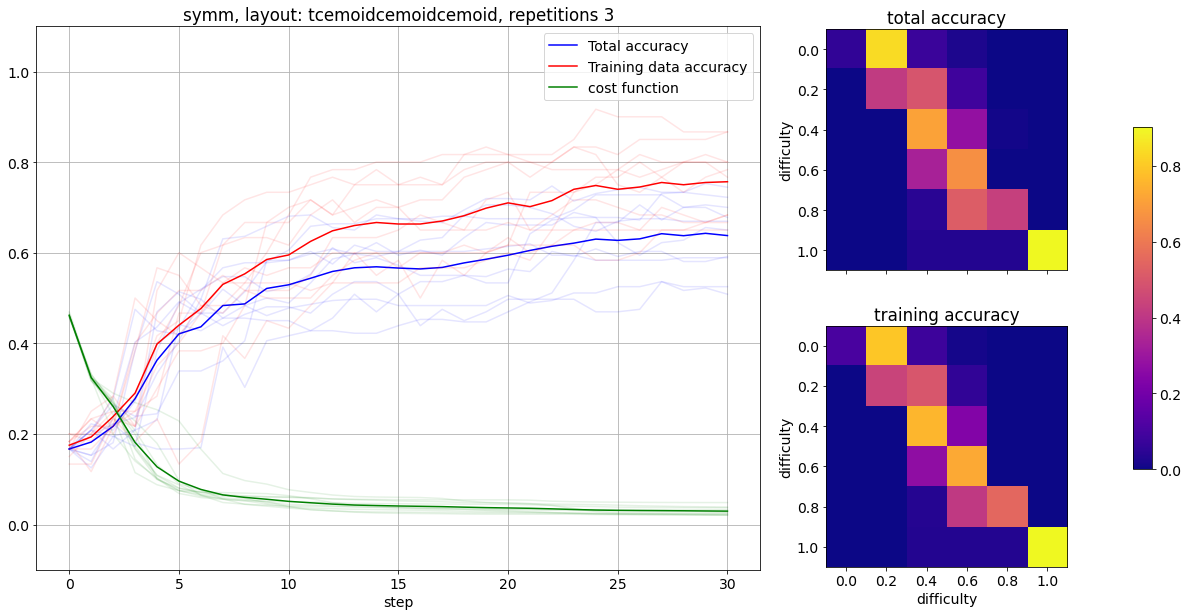

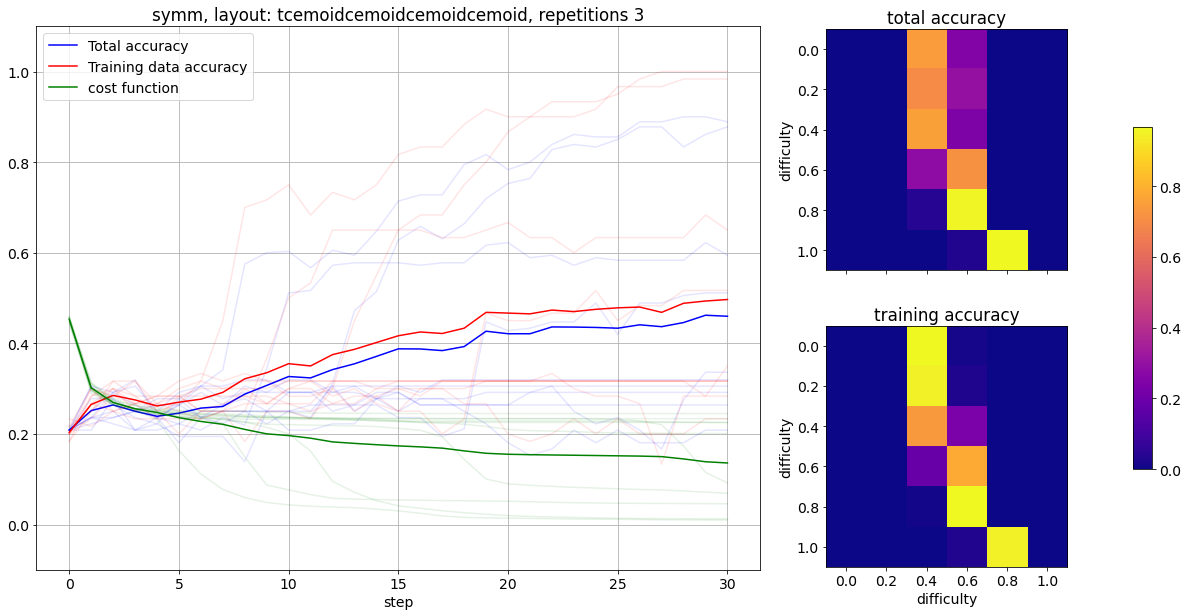

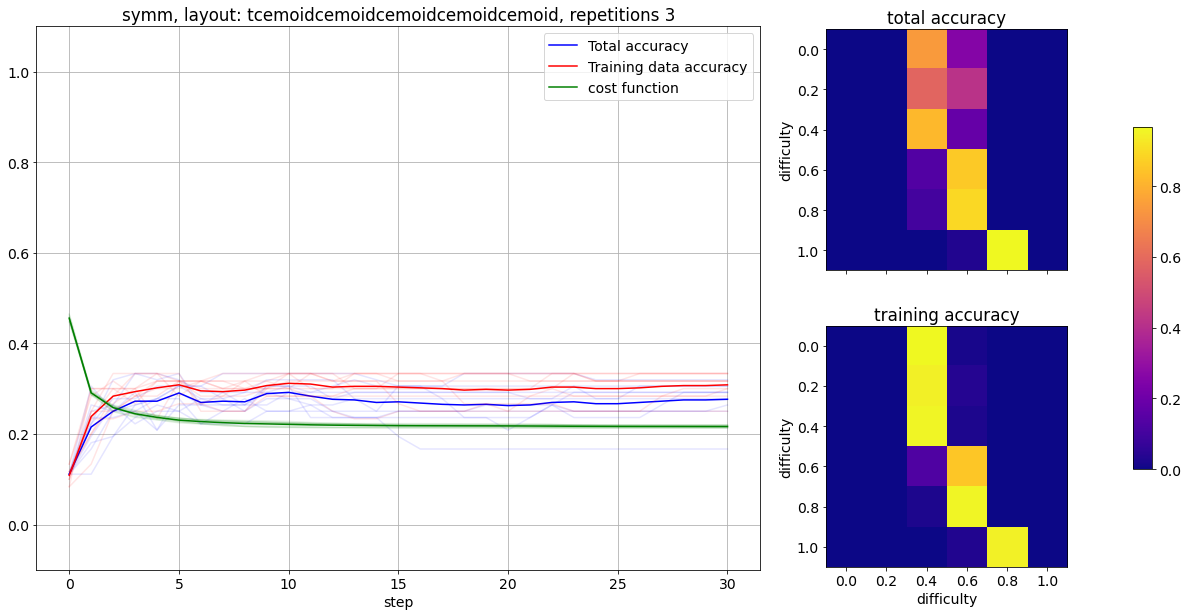

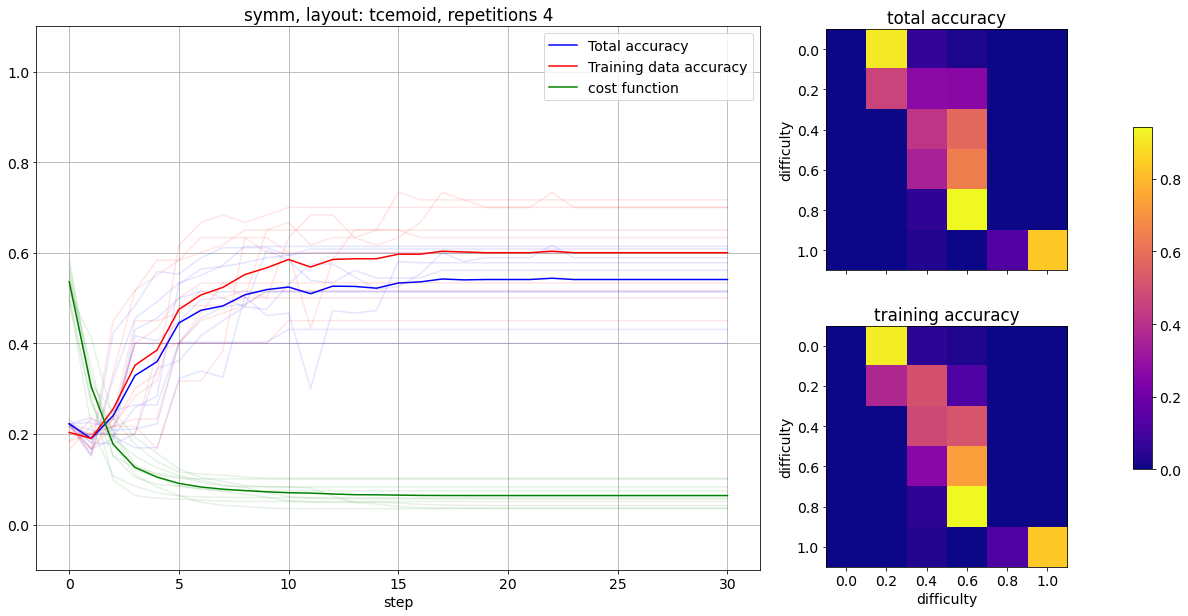

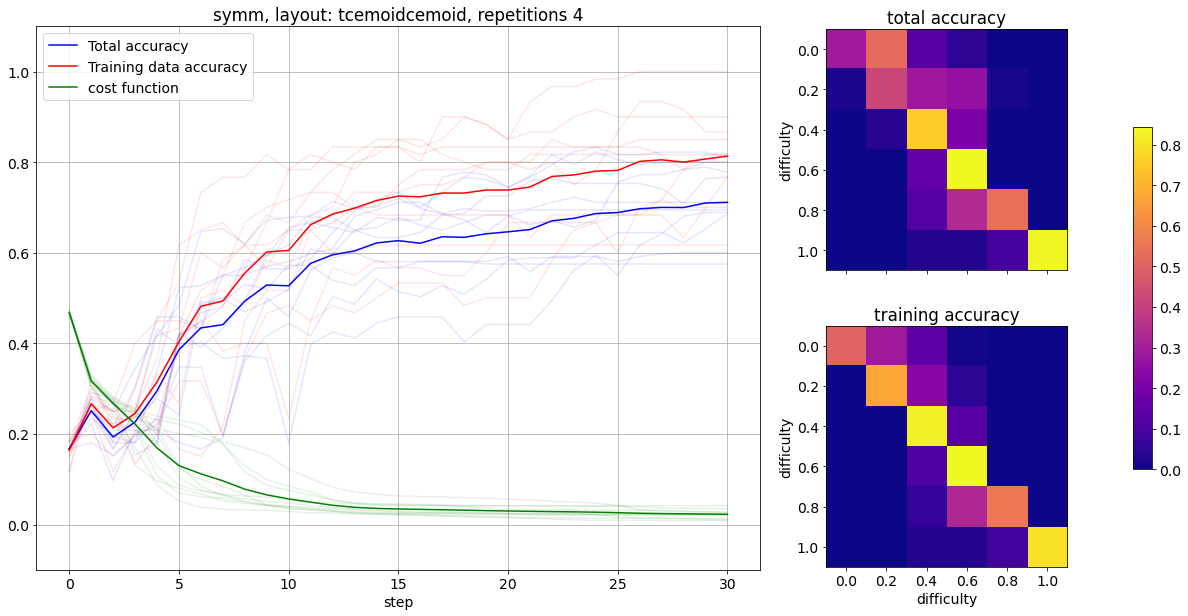

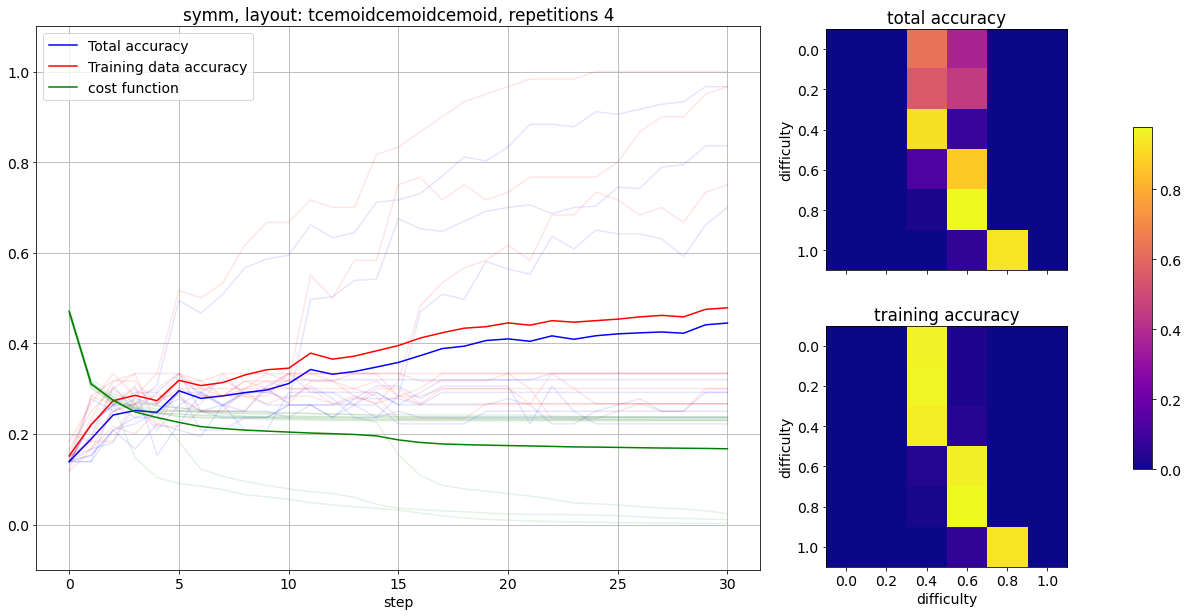

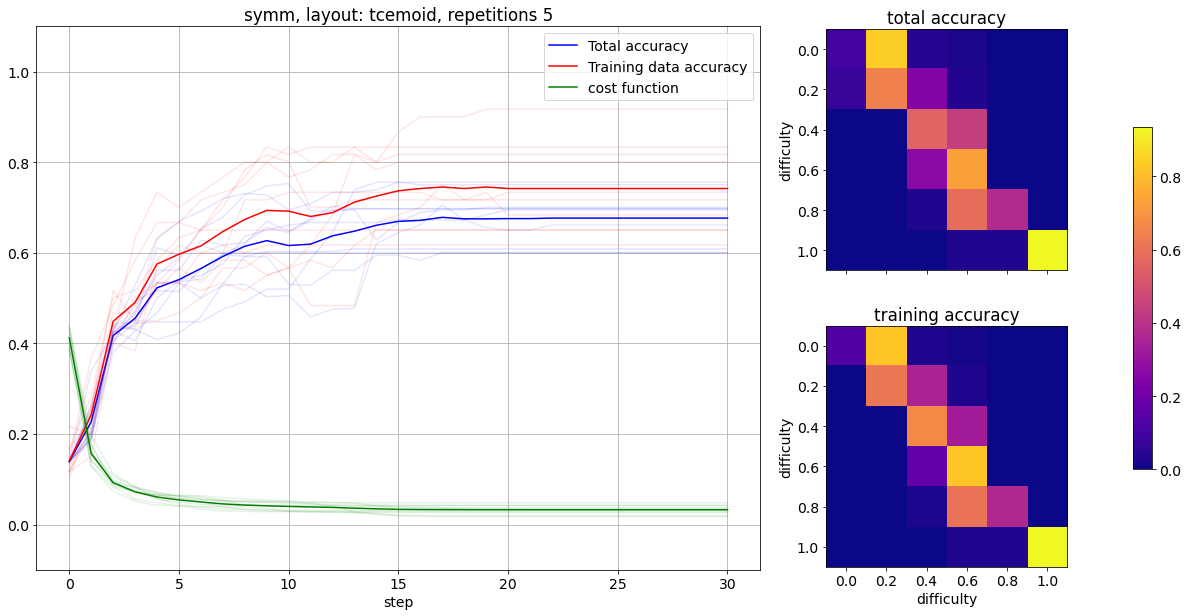

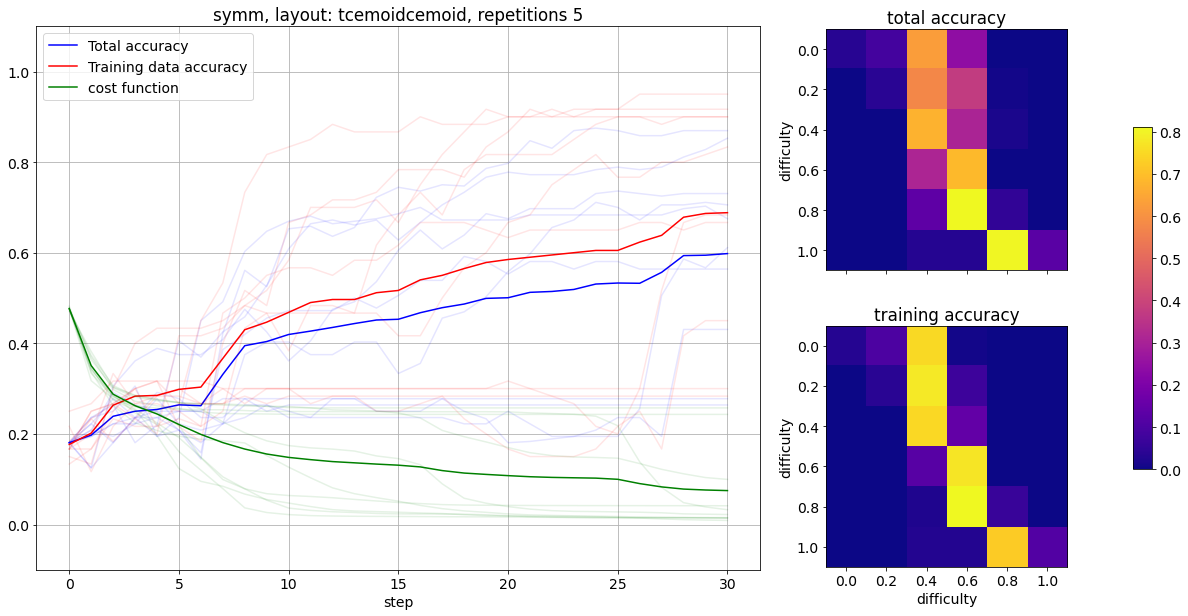

In [7]:
single_plots(base_path, 8000, save=True)

## Non symmetric case

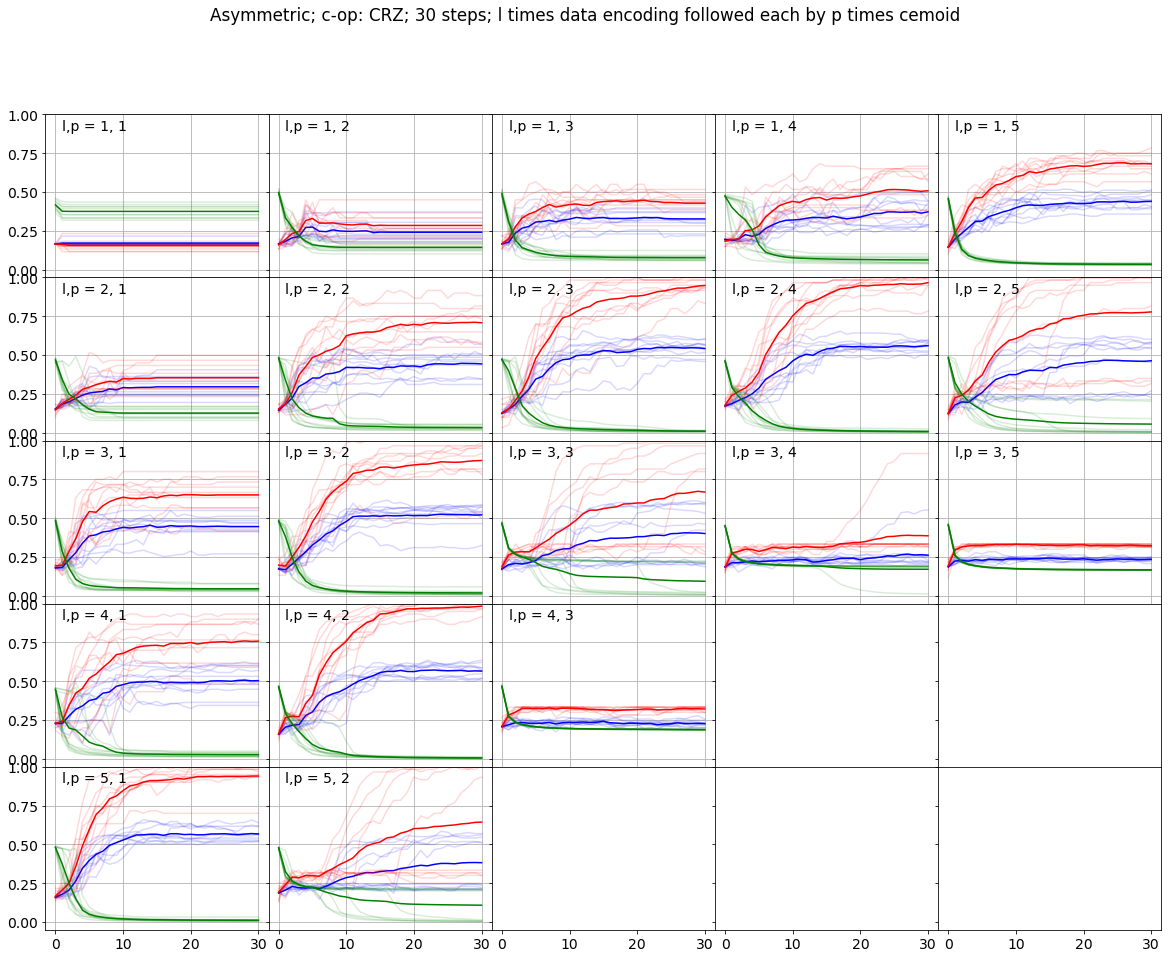

In [8]:
overview_plot(base_path, 9000, save=True)

<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+list(np.round(np.linspace(0, 1, 6), 2)))
<ipython-input-3-9e1daa1d1ae0>:57: UserWarning: FixedFormatter should only be used together with FixedLocator


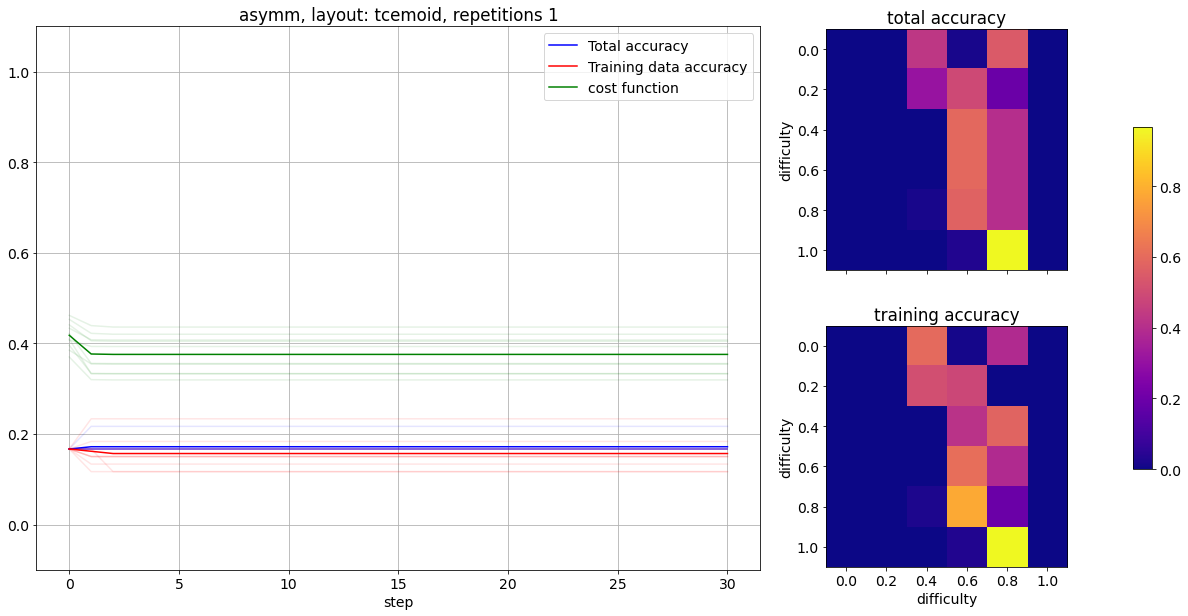

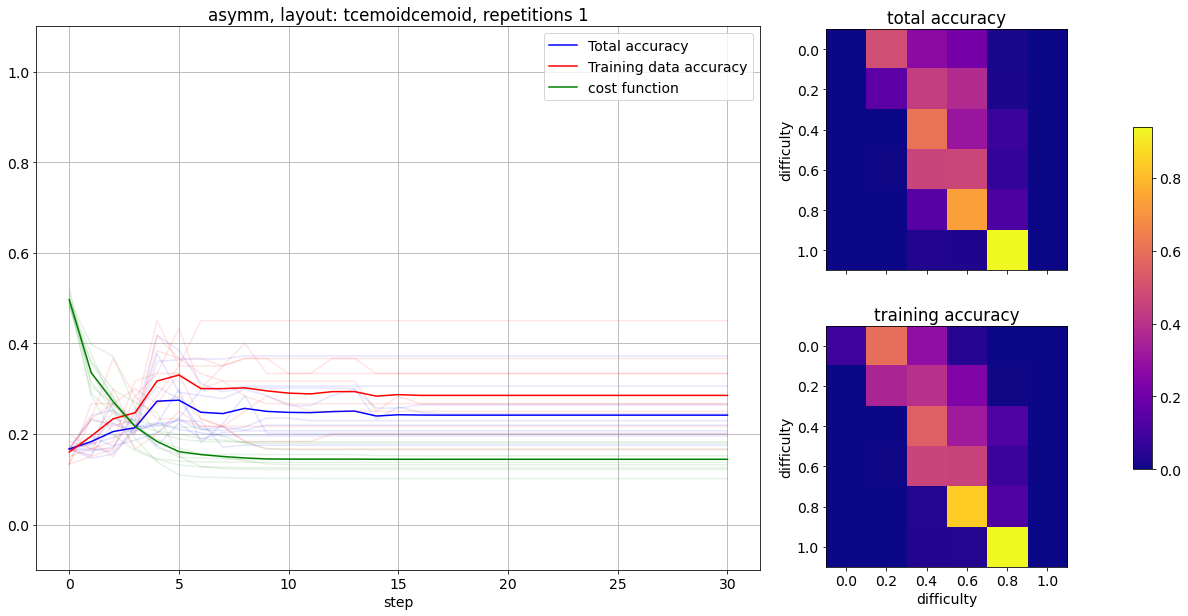

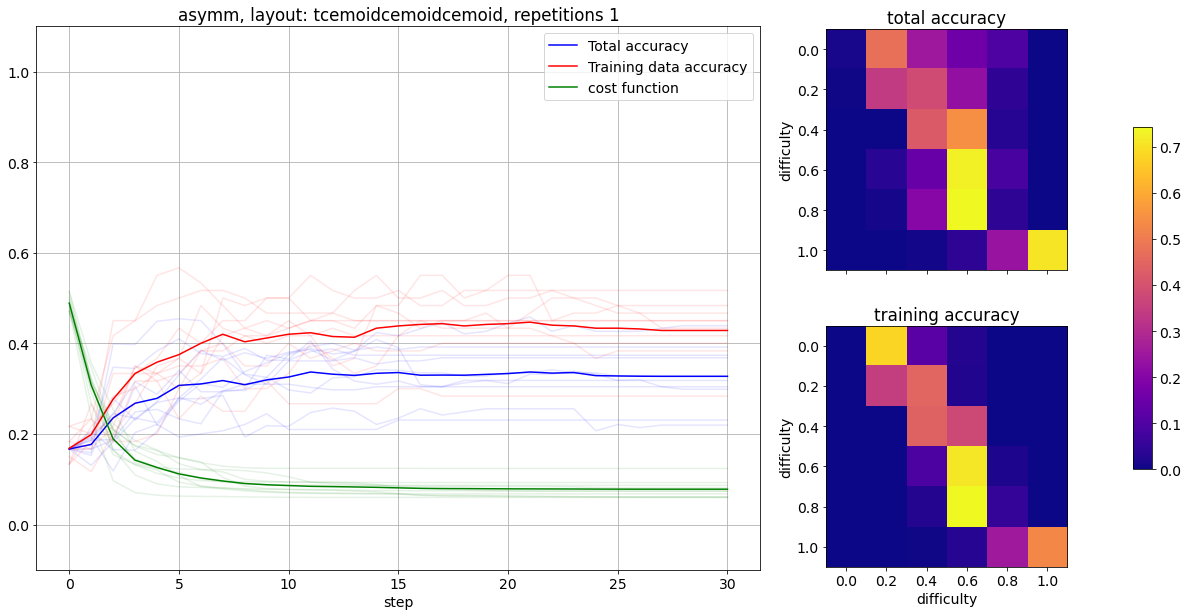

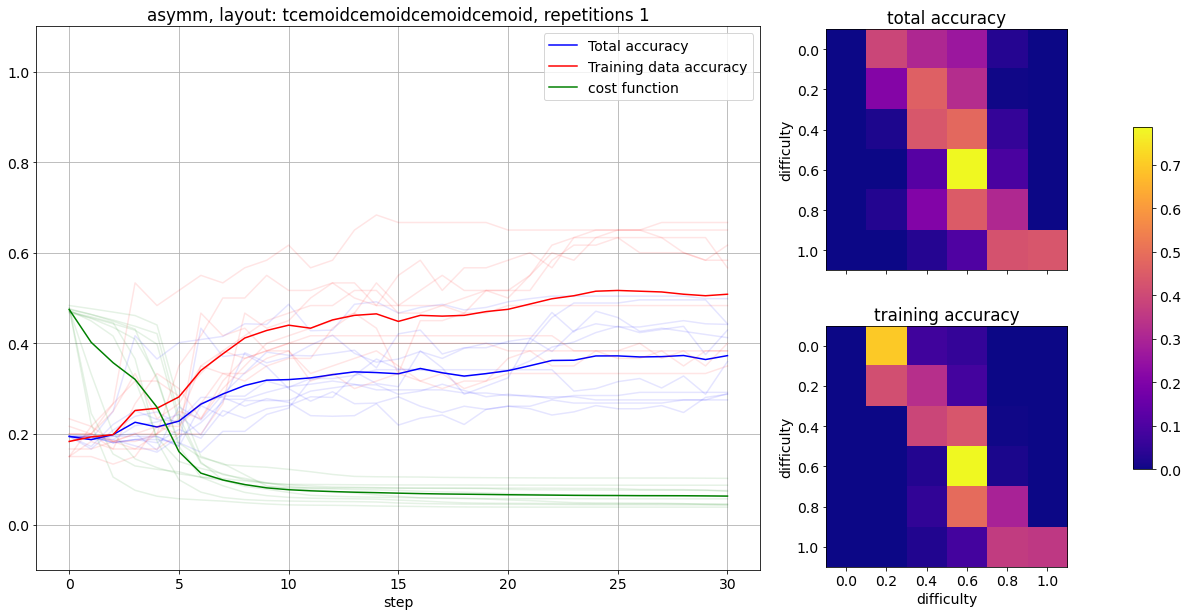

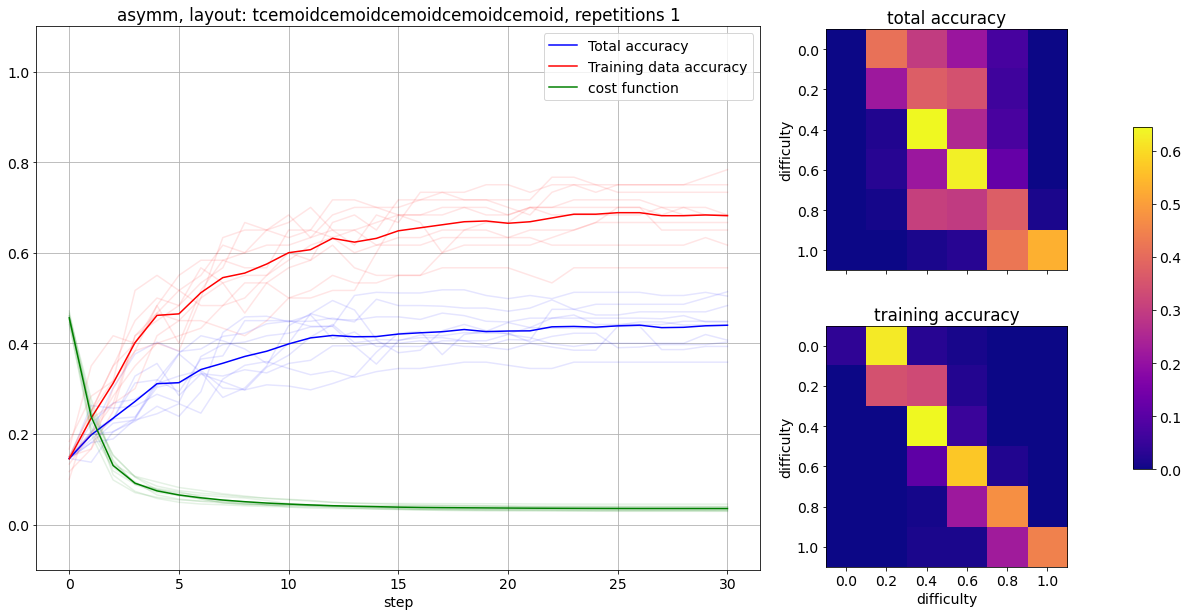

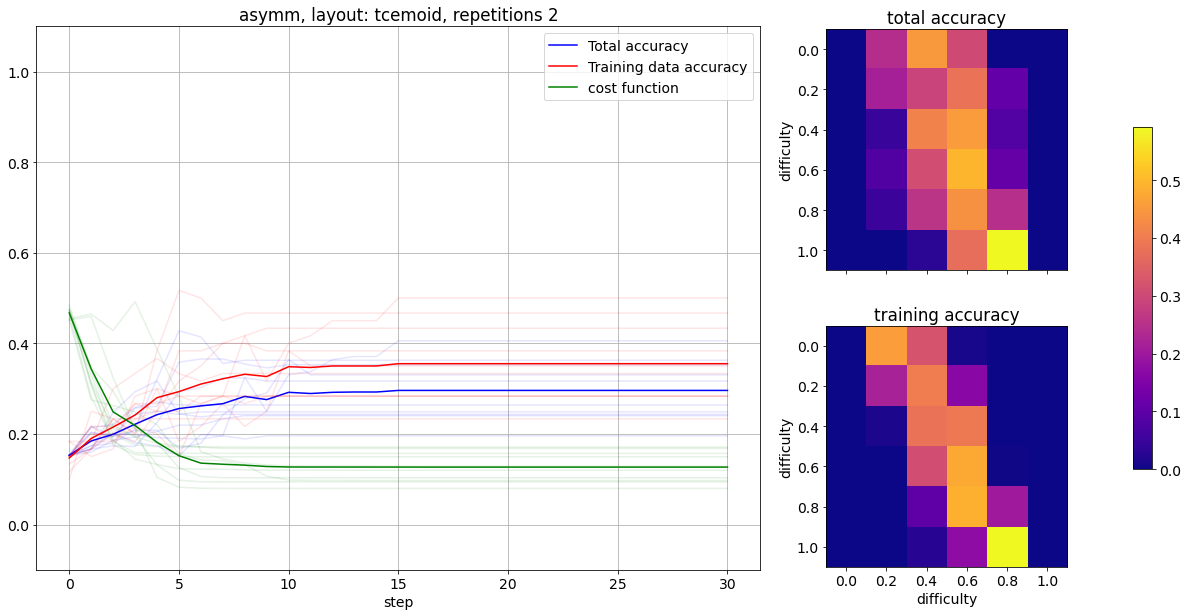

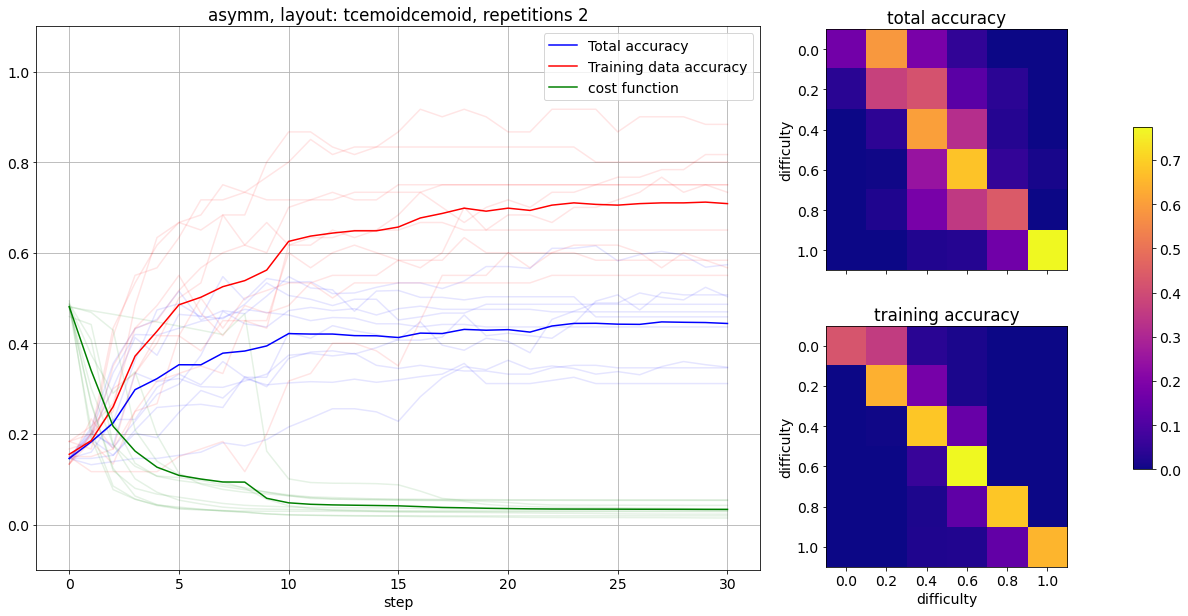

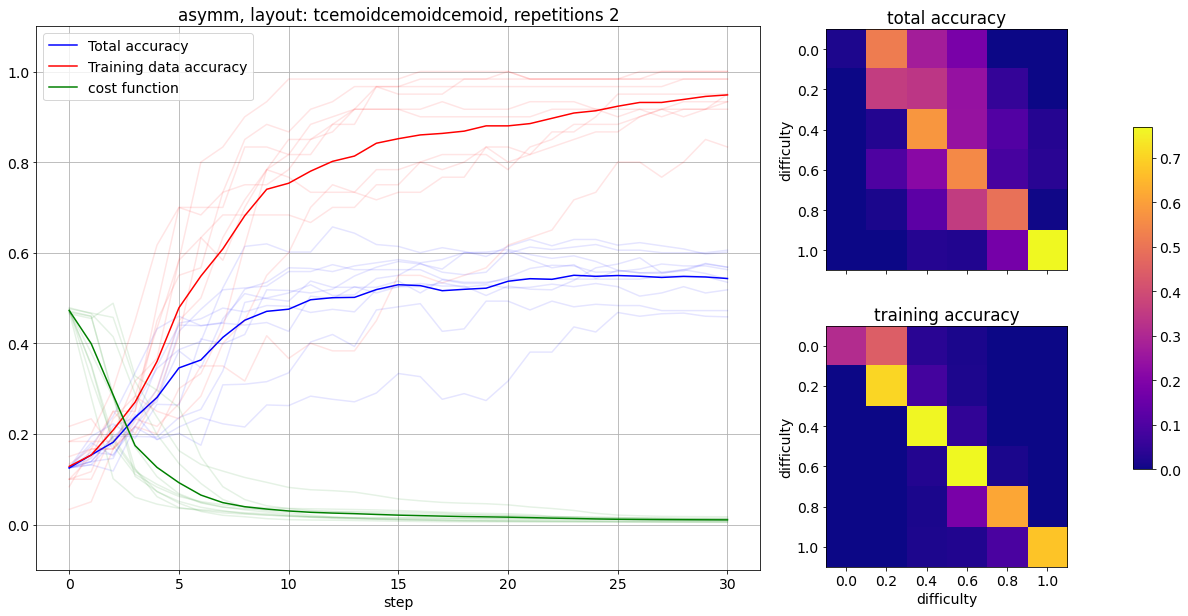

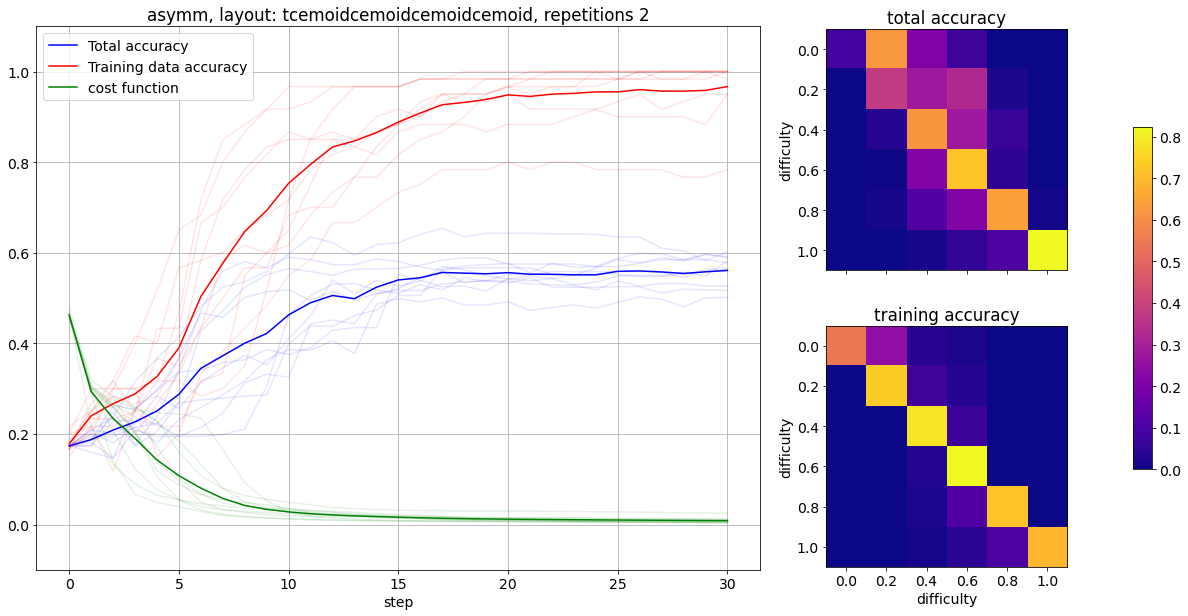

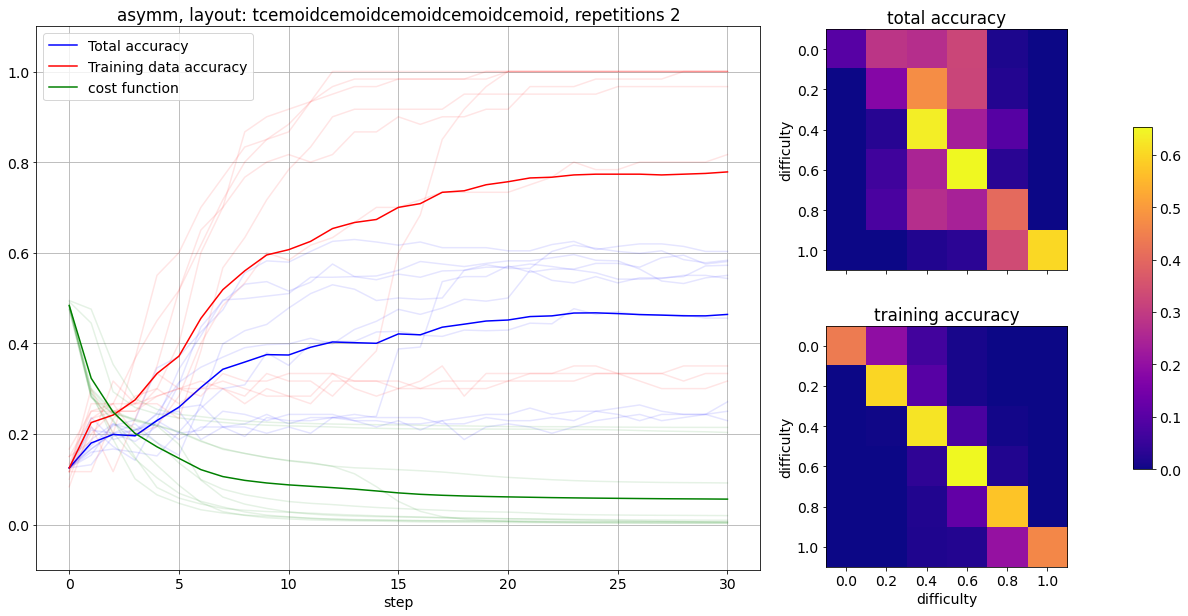

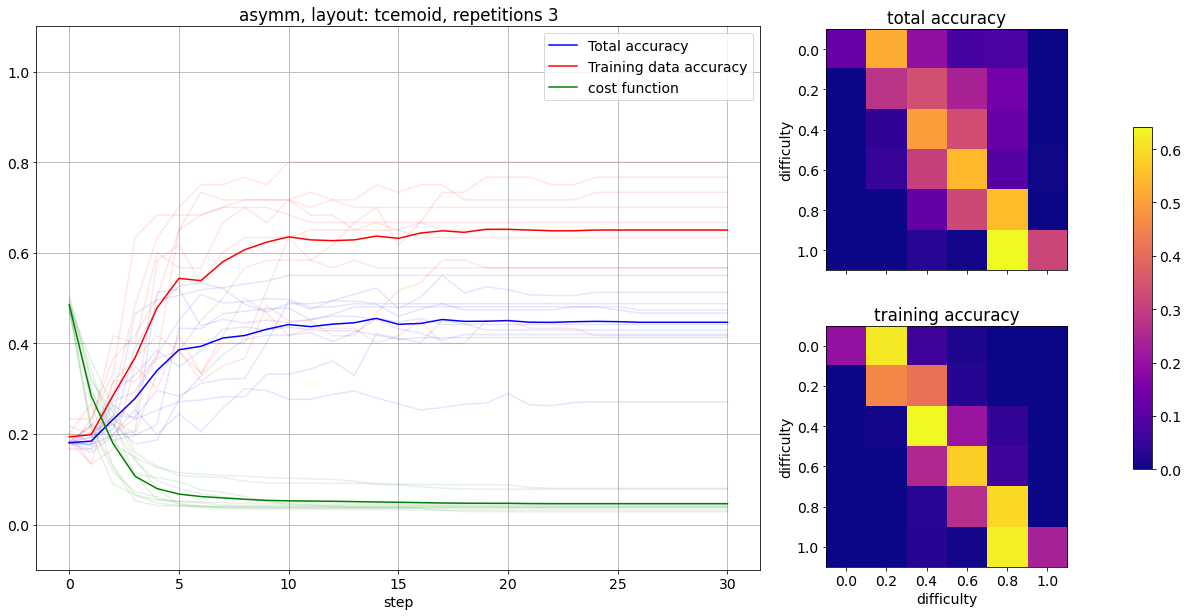

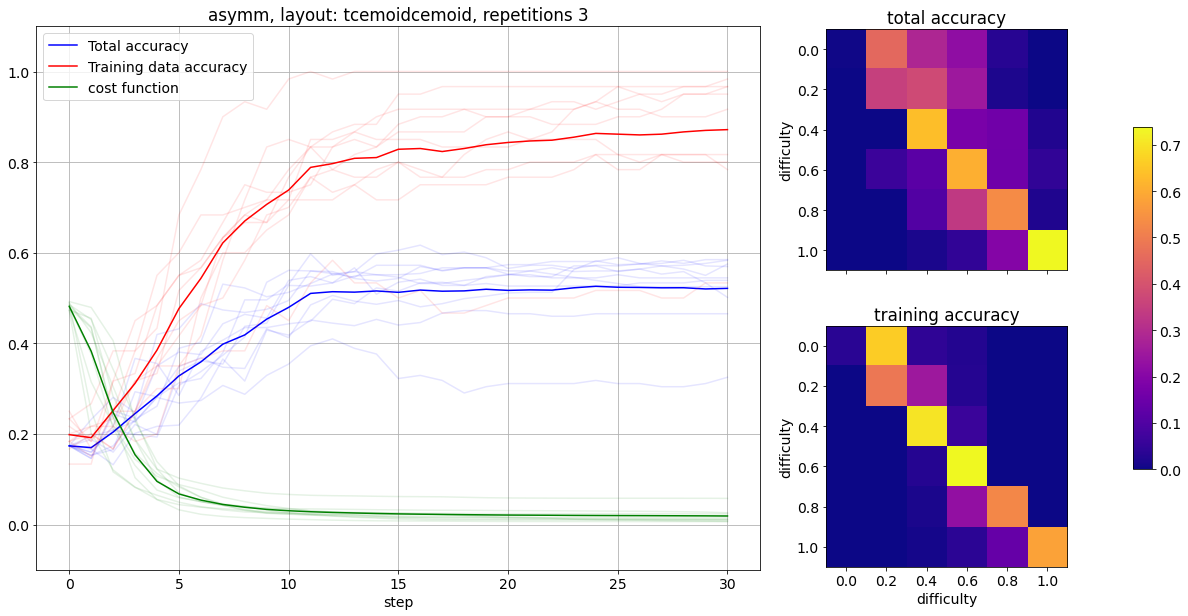

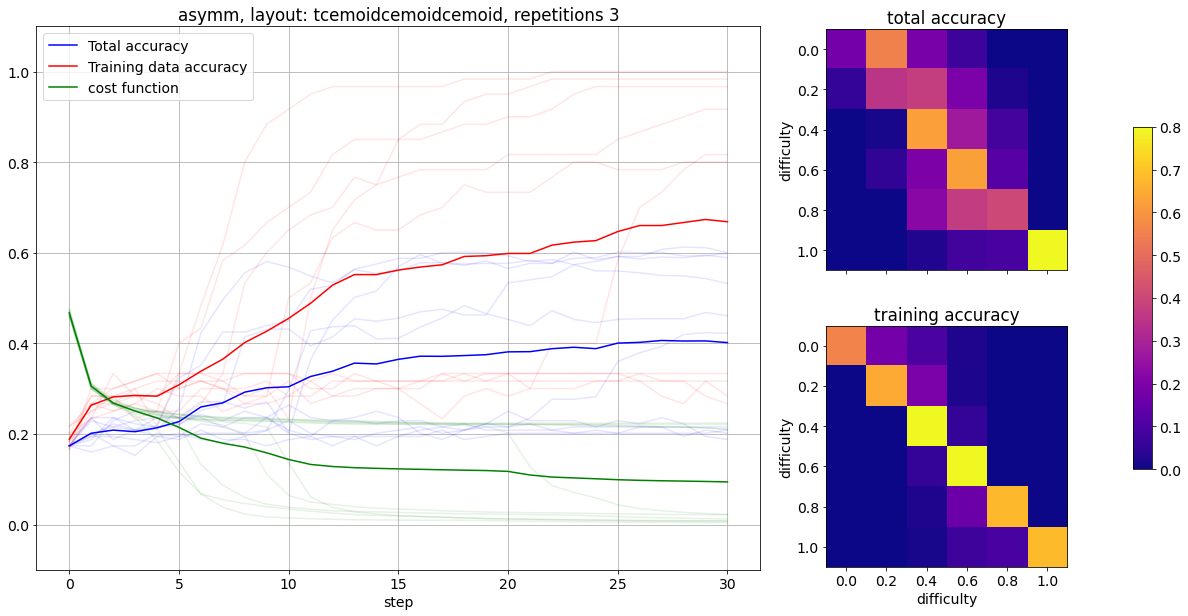

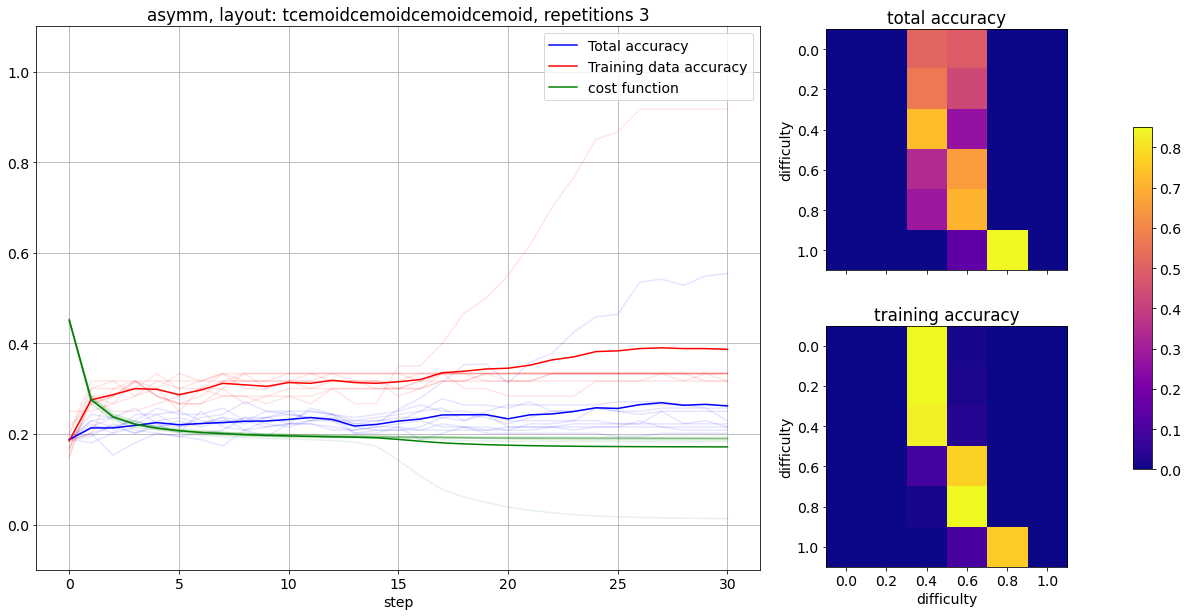

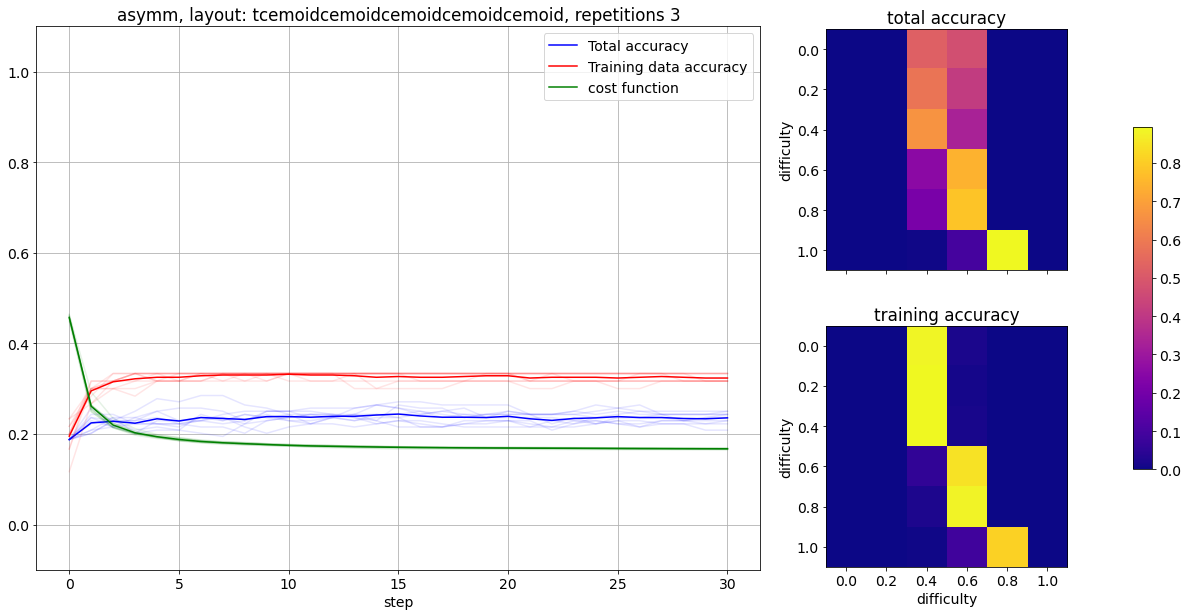

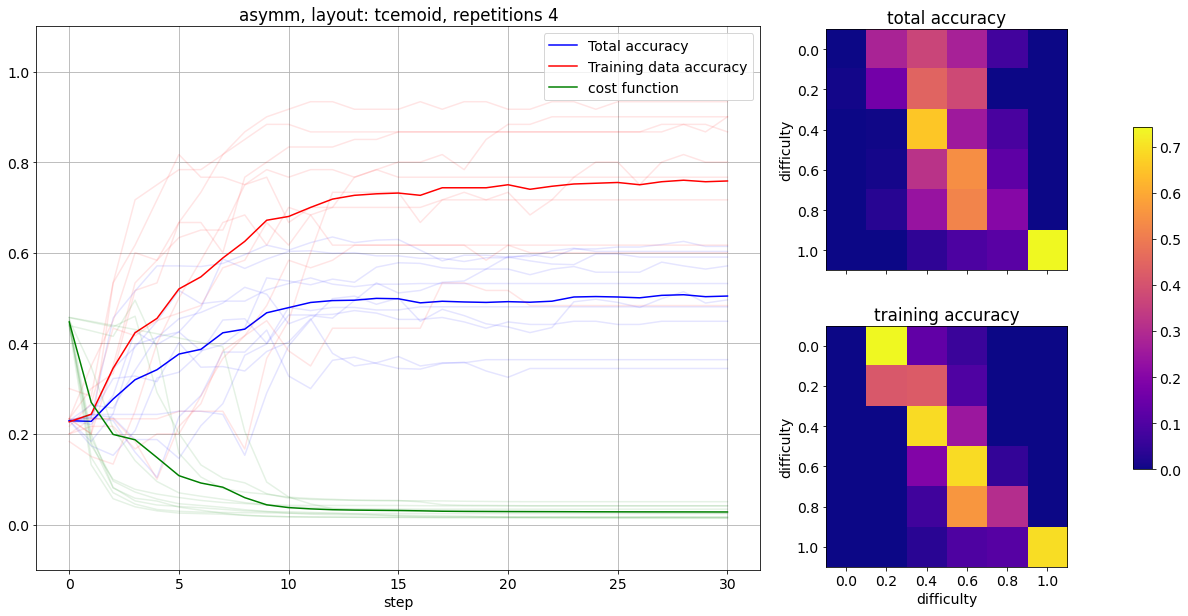

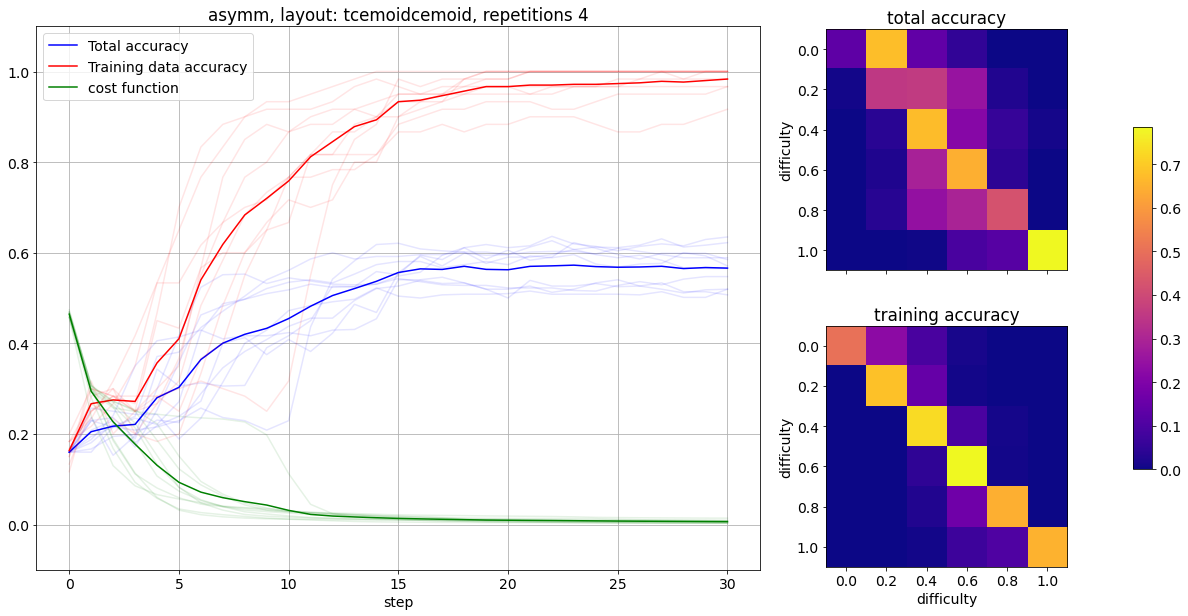

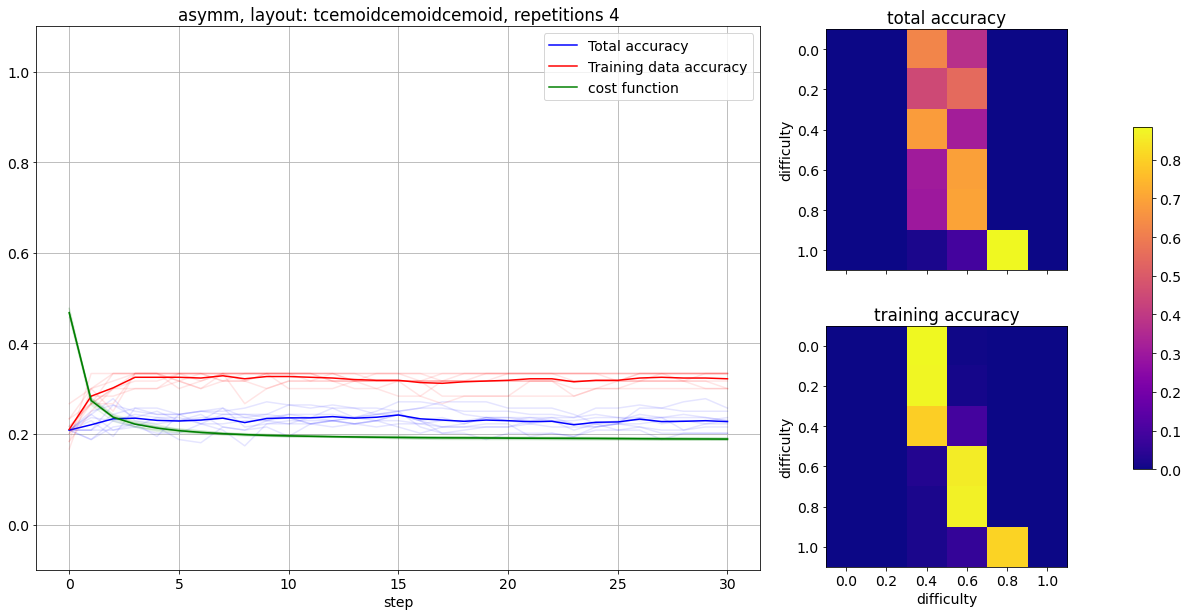

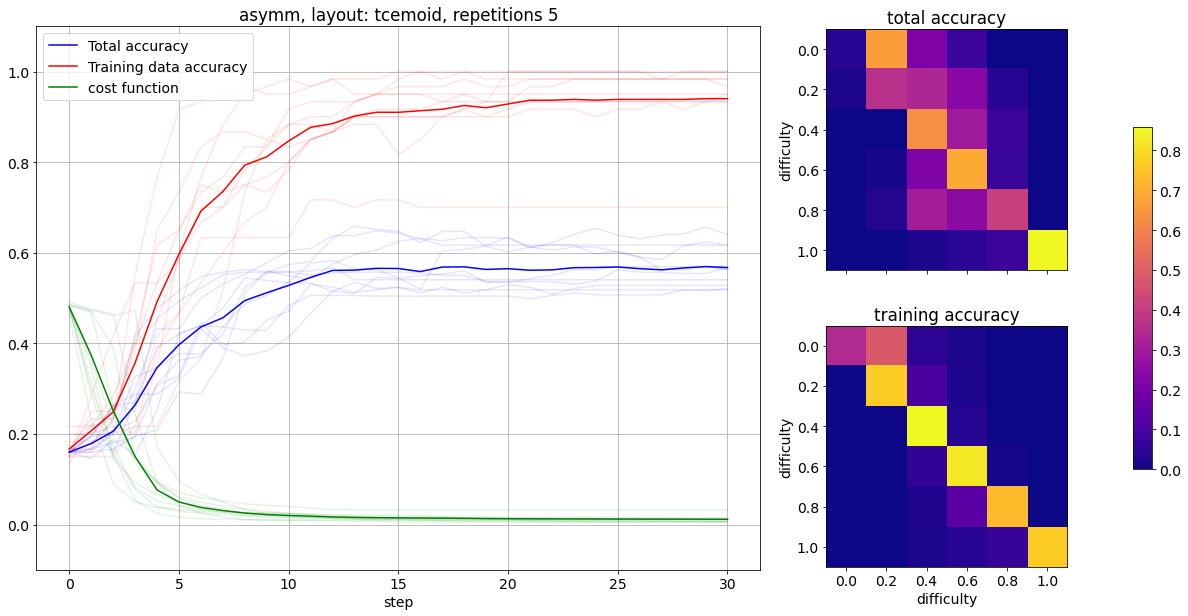

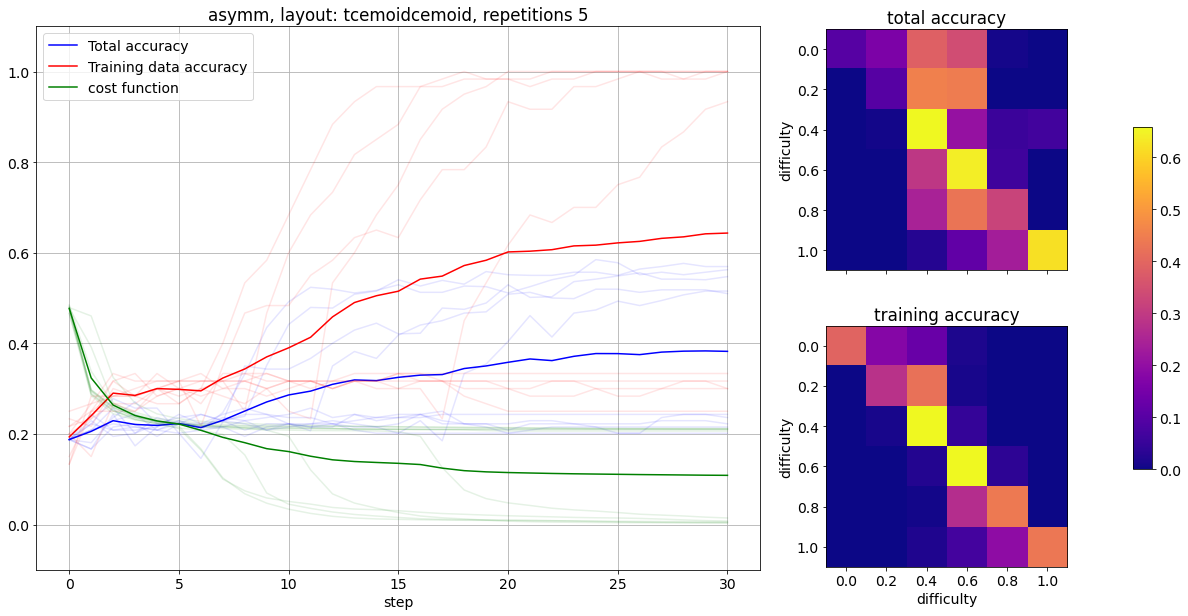

In [9]:
single_plots(base_path, 9000, save=True)

# Random layouts

In [10]:
base_path = os.getcwd() + '/cluster_output/pdg_rand_layout_1/'

## Symmetric case

In [11]:
i = 0
start = 6000
n = 20
for marker in range(start,start+n):
    with open(base_path+str(marker)+'/params.txt') as f:
        params = f.readlines()[0]
        args = params.split(" ")
        print(str(i)+' '+args[args.index('-l')+1])
        i+=1

FileNotFoundError: [Errno 2] No such file or directory: '/Users/p390728/pqc/pqc-symmetry/cluster_output/pdg_rand_layout_1/6000/params.txt'

In [ ]:
single_plots(base_path, 6000, save=True)

## Non symmetric case

In [ ]:
single_plots(base_path, 7000, save=True)

### Histogram of accuracy deltas for random layouts

In [ ]:
start = 6000

In [ ]:
symm_final_acc = []
symm_final_train_acc = []
symm_final_cost = []
for marker in range(start,start+n):
    filenames = next(os.walk(base_path+str(marker)), (None, None, []))[2]
    symmetric = [np.load(base_path + str(marker) + '/' + str(i), allow_pickle=True).item() for i in filenames if i != 'params.txt']
    
    epoch_acc = np.array([i['total accuracy'][-1] for i in symmetric])
    epoch_train_acc = np.array([i['training accuracy'][-1] for i in symmetric])
    epoch_cost = (torch.tensor([i['cost function'][-1] for i in symmetric])).detach().numpy()
    avg_epoch_acc = np.average(epoch_acc, axis=0)
    avg_epoch_train_acc = np.average(epoch_train_acc, axis=0)
    avg_epoch_cost = np.average(epoch_cost, axis=0)
    
    symm_final_acc.append(avg_epoch_acc.trace()/6)
    symm_final_train_acc.append(avg_epoch_train_acc.trace()/6)
    symm_final_cost.append(avg_epoch_cost)

In [ ]:
asymm_final_acc = []
asymm_final_train_acc = []
asymm_final_cost = []
for marker in range(start+1000, start+n+1000):
    filenames = next(os.walk(base_path+str(marker)), (None, None, []))[2]
    asymmetric = [np.load(base_path + str(marker) + '/' + str(i), allow_pickle=True).item() for i in filenames if i != 'params.txt']
    
    epoch_acc = np.array([i['total accuracy'][-1] for i in asymmetric])
    epoch_train_acc = np.array([i['training accuracy'][-1] for i in asymmetric])
    epoch_cost = (torch.tensor([i['cost function'][-1] for i in asymmetric])).detach().numpy()
    avg_epoch_acc = np.average(epoch_acc, axis=0)
    avg_epoch_train_acc = np.average(epoch_train_acc, axis=0)
    avg_epoch_cost = np.average(epoch_cost, axis=0)
    
    asymm_final_acc.append(avg_epoch_acc.trace()/6)
    asymm_final_train_acc.append(avg_epoch_train_acc.trace()/6)
    asymm_final_cost.append(avg_epoch_cost)

In [ ]:
d_final_acc = np.array(symm_final_acc) - np.array(asymm_final_acc)
d_final_train_acc = np.array(symm_final_train_acc) - np.array(asymm_final_train_acc)
d_final_cost = np.array(symm_final_cost) - np.array(asymm_final_cost)

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.gca()

plt.plot(d_final_acc, label='Total accuracy',color='blue',marker='s')
plt.plot(d_final_train_acc, label='Training data accuracy',color='red',marker='s')
plt.plot(d_final_cost, label='Final cost',color='green',marker='s')

plt.axhline(y=np.average(d_final_acc), color='blue', linestyle='--')
plt.axhline(y=np.average(d_final_train_acc), color='red', linestyle='--')
plt.axhline(y=np.average(d_final_cost), color='green', linestyle='--')

plt.xlabel('layout')
#ax.set_ylim([0.3, 1.2])

plt.xticks(np.arange(0, 20, step=1))

plt.title('difference between symm-asymm accuracies')
plt.legend()
plt.grid(axis='both')
plt.savefig(base_path+'/figs/rand_layout_deltas')
plt.show()


In [ ]:
plt.figure(figsize=(16, 8))
plt.hist(d_final_acc,color='blue', label='Total accuracy',alpha=0.3)
plt.hist(d_final_train_acc,color='red', label='Training data accuracy',alpha=0.3)
plt.hist(d_final_cost,color='green', label='Final cost',alpha=0.3)

plt.title('Histogram for symm-asymm values')
plt.legend()
plt.savefig(base_path+'/figs/rand_layout_deltas_hist')
plt.show()


In [ ]:
# data to plot
n_groups = len(d_final_acc)
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)

'''
plt.plot(d_final_acc, label='Total accuracy',color='blue',marker='s')
plt.plot(d_final_train_acc, label='Training data accuracy',color='red',marker='s')
plt.plot(d_final_cost, label='Final cost',color='green',marker='s')

plt.axhline(y=np.average(d_final_acc), color='blue', linestyle='--')
plt.axhline(y=np.average(d_final_train_acc), color='red', linestyle='--')
plt.axhline(y=np.average(d_final_cost), color='green', linestyle='--')
'''
# create plot


fig, ax = plt.subplots(figsize=(9,6))




bar_width = 0.5
index = 2*np.arange(n_groups)
opacity = 0.8

rects1 = plt.bar(index, d_final_acc, bar_width,
alpha=opacity,
color='blue',
label='Total accuracy')


rects2 = plt.bar(index + bar_width, d_final_train_acc, bar_width,
alpha=opacity,
color='red',
label='Training data accuracy')

rects3 = plt.bar(index + 2*bar_width, d_final_cost, bar_width,
alpha=opacity,
color='green',
label='Final cost')


plt.axhline(y=np.average(d_final_acc), color='blue', linestyle='--')
plt.axhline(y=np.average(d_final_train_acc), color='red', linestyle='--')
plt.axhline(y=np.average(d_final_cost), color='green', linestyle='--')


plt.xlabel('Layout')
plt.ylabel('Deltas')
plt.title('difference symm - asymm')
plt.grid()
#plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.savefig(base_path+'/figs/rand_layout_deltas_barchart')
plt.show()

